# KIWI PROJECT

**The goal of the projest is to count the kiwi seeds and assess their total voulme.**

To segment all kiwi seeds in the image I planned to use 2D Deep Learning approach. I decided on using fastai library as it is the best tool for working on 2D images. 

---

In [16]:
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets

from pathlib import Path
from IPython.display import Image

#### PROJECT FUNCTIONS

In [17]:
def info(im, name='Kiwi'):
    """
    Prints info about image.
    
    C: 2021.05.24 / U: 2021.05.28
    """
    print(f'{name}:  max={im.max():.2f}, mean={im.mean():.2f}, min={im.min():.2f}, shape={im.shape}')

In [18]:
def show_crossection(im, sl=64, dir=0, type='S', title='KIWI', figsize=(10,10)):
    """
    Displays cross-section of an image.
    
    Parameters:
    im - an image [np.array],
    sl - slice number to display,
    dir - cross-section direction. In genral it refers to sagital, coronal, axial cuts. Accepted values are: 0, 1, 2.
    type - type of displayed cross-section. Accepted values as a string:
                1. 'S' - single slice, the number of a slice is given in 'sl' parameter,
                2. 'M' - Maximum Intensity Projection (MIP),
                3. 'm' - minimum Intensity Projection (mIP)
    title - a title of the image,
    figsize - size of the figure.
    
    
    C: 2021.05.24 / U: 2021.05.28
    """
    
    cmap = 'gray'
    interp = 'nearest'
    orig ='lower'
    axis = 'on'
    
    fig, ax = plt.subplots(figsize=figsize)
    if type == 'S' :  
        if dir==2:
            ax.imshow(im[:,:,sl], cmap=cmap, interpolation=interp, origin=orig)
        if dir==1:
            ax.imshow(im[:,sl,:], cmap=cmap, interpolation=interp, origin=orig)
        if dir==0:
            ax.imshow(im[sl,:,:], cmap=cmap, interpolation=interp, origin=orig)
    elif type=='M':
        ax.imshow(im.max(dir), cmap=cmap, interpolation=interp, origin=orig)
    elif type=='m':
        ax.imshow(im.min(dir), cmap=cmap, interpolation=interp, origin=orig)    
    ax.set_title(title, fontsize=18, weight='bold')    
    ax.axis(axis)
    plt.show()    

In [66]:
def show_all_crossections(im, sl=[], type='S', titles=['Sagital', 'Coronal', 'Axial'], title='KIWI', figsize=(18,7)):
    """
    Displays all cross-sections of an image.
    
    Parameters:
    im - an image [np.array],
    sl - slice numbers to display. List of 3 slice numbers to display for each cut. If sl=[] the middle slice in each direction is displayed.
    type - type of displayed cross-section. Accepted values as a string:
                1. 'S' - single slice, the number of a slice is given in 'sl' parameter,
                2. 'M' - Maximum Intensity Projection (MIP),
                3. 'm' - minimum Intensity Projection (mIP)
    titles - a titles of cross-sections,
    title - the main title of the imge,
    figsize - size of the figure.
    
    
    C: 2021.05.24 / U: 2021.05.28
    """
    
    cmap='gray'
    interp='nearest'
    orig='lower'
    axis = bool(1)
    asp = 'equal'
    
    if len(sl)<3:
        sl=np.asarray((np.array(im.shape)//2), np.uint)
        
    f,ax = plt.subplots(1,3,figsize=figsize)
    axs = ax.flat[:]
    
    _ =[a.axis(axis) for a in axs]
    _ =[a.axes.axes.set_aspect(asp) for a in axs]
    
    if type=='M':
        _ = [a.imshow(im.max(d), cmap=cmap, interpolation=interp, origin=orig) for d, a in zip(range(3), axs)]
        _ =[a.set_title(f'{t}', fontsize=18) for a, t in zip(axs, titles)]
    if type=='m':
        _ = [a.imshow(im.min(d), cmap=cmap, interpolation=interp, origin=orig) for d, a in zip(range(3), axs)]
        _ =[a.set_title(f'{t}', fontsize=18) for a, t in zip(axs, titles)]
    if type=='S':
        _ = axs[0].imshow(im[sl[0],:,:],cmap=cmap, interpolation=interp, origin=orig)
        _ = axs[1].imshow(np.rot90(im[:,sl[1],:],1),cmap=cmap, interpolation=interp, origin=orig)
        _ = axs[2].imshow(im[:,:,sl[2]],cmap=cmap, interpolation=interp, origin=orig)   
        _ =[a.set_title(f'{t} [sl. {s}/{sh}]', fontsize=18) for a, t, s, sh  in zip(axs, titles, sl, im.shape)]
        
    plt.suptitle(title, fontsize=22, weight='bold')
    plt.tight_layout()
    plt.show()    

In [44]:
#show_all_crossections(ko, type='S')

In [48]:
#show_crossection(ko,sl=64, dir=2, type='S')

In [32]:
def replace_data_nifti(niiO, data):
    """
    Replaces data in a NIFTI structure. It enables to save a 'data' as a NIFIT file to the disk.
    
    Parameters:
    nii0 - a nifti structure loaded from a file,
    data - data (np.array) to replace in the nii0 structure.
    
    C: 2021.05.24 / U: 2021.05.28
    """
    import time
    hdrO = niiO.header
    hdrO['descrip'] = 'BMED2021 ({}) - nibabel ver. ' + nib.__version__ + ' (by MK)'.format(time.strftime("%Y.%m.%d"))
    img = nib.Nifti1Image(data, affine=niiO.affine, header=hdrO)
    img.set_data_dtype(data.dtype.name)
    return img

---

# LOAD KIWI IMAGE

The first step is to load and display the kiwi image.I this project I will work on NIFTI image named as: `kiwi_20050217191129_131073_RARE_high_res_axial.nii.gz` that is provided in the project data folder.



For ease we will use abbreviations for selected variable names:
- kiwi -> k,
- original -> o, e.g. `ko` stands for kiwi original (image),
- interpolated ->i, e.g. `ki` stands for kiwi interpolated (image).

In [78]:
data = Path('data')
ko_name = data / 'ko.nii.gz'
ko_nii = nib.load(ko_name)
ko = ko_nii.get_fdata()

info(ko, 'Loaded kiwi')

Loaded kiwi:  max=32766.00, mean=3374.98, min=71.00, shape=(256, 256, 128)


As we can see **below** the image quality is not the same in all cross-sections. This is a concuquence of voxel anisotropy. There is one plane with hight resoultion 0.23 x 0.23 mm2, however in two others resolution is two times lower 0.23 x 0.5 mm2. A voxel size in high resolution plane is smaller (we can see more details) in contrast to two others cuts, with bigger voxel size, where image seems more blurry. This is tightly connected with number of slices in each direction. There are 256 slices in low-resolution direction and 128 in high-resolution one. Softwares like`ITK-SNAP` deals with this problem easily (as in the image above), howewer when images are displayed without taking into account voxel dimensions the sections look like in the figure **below (bottom figure)**. 

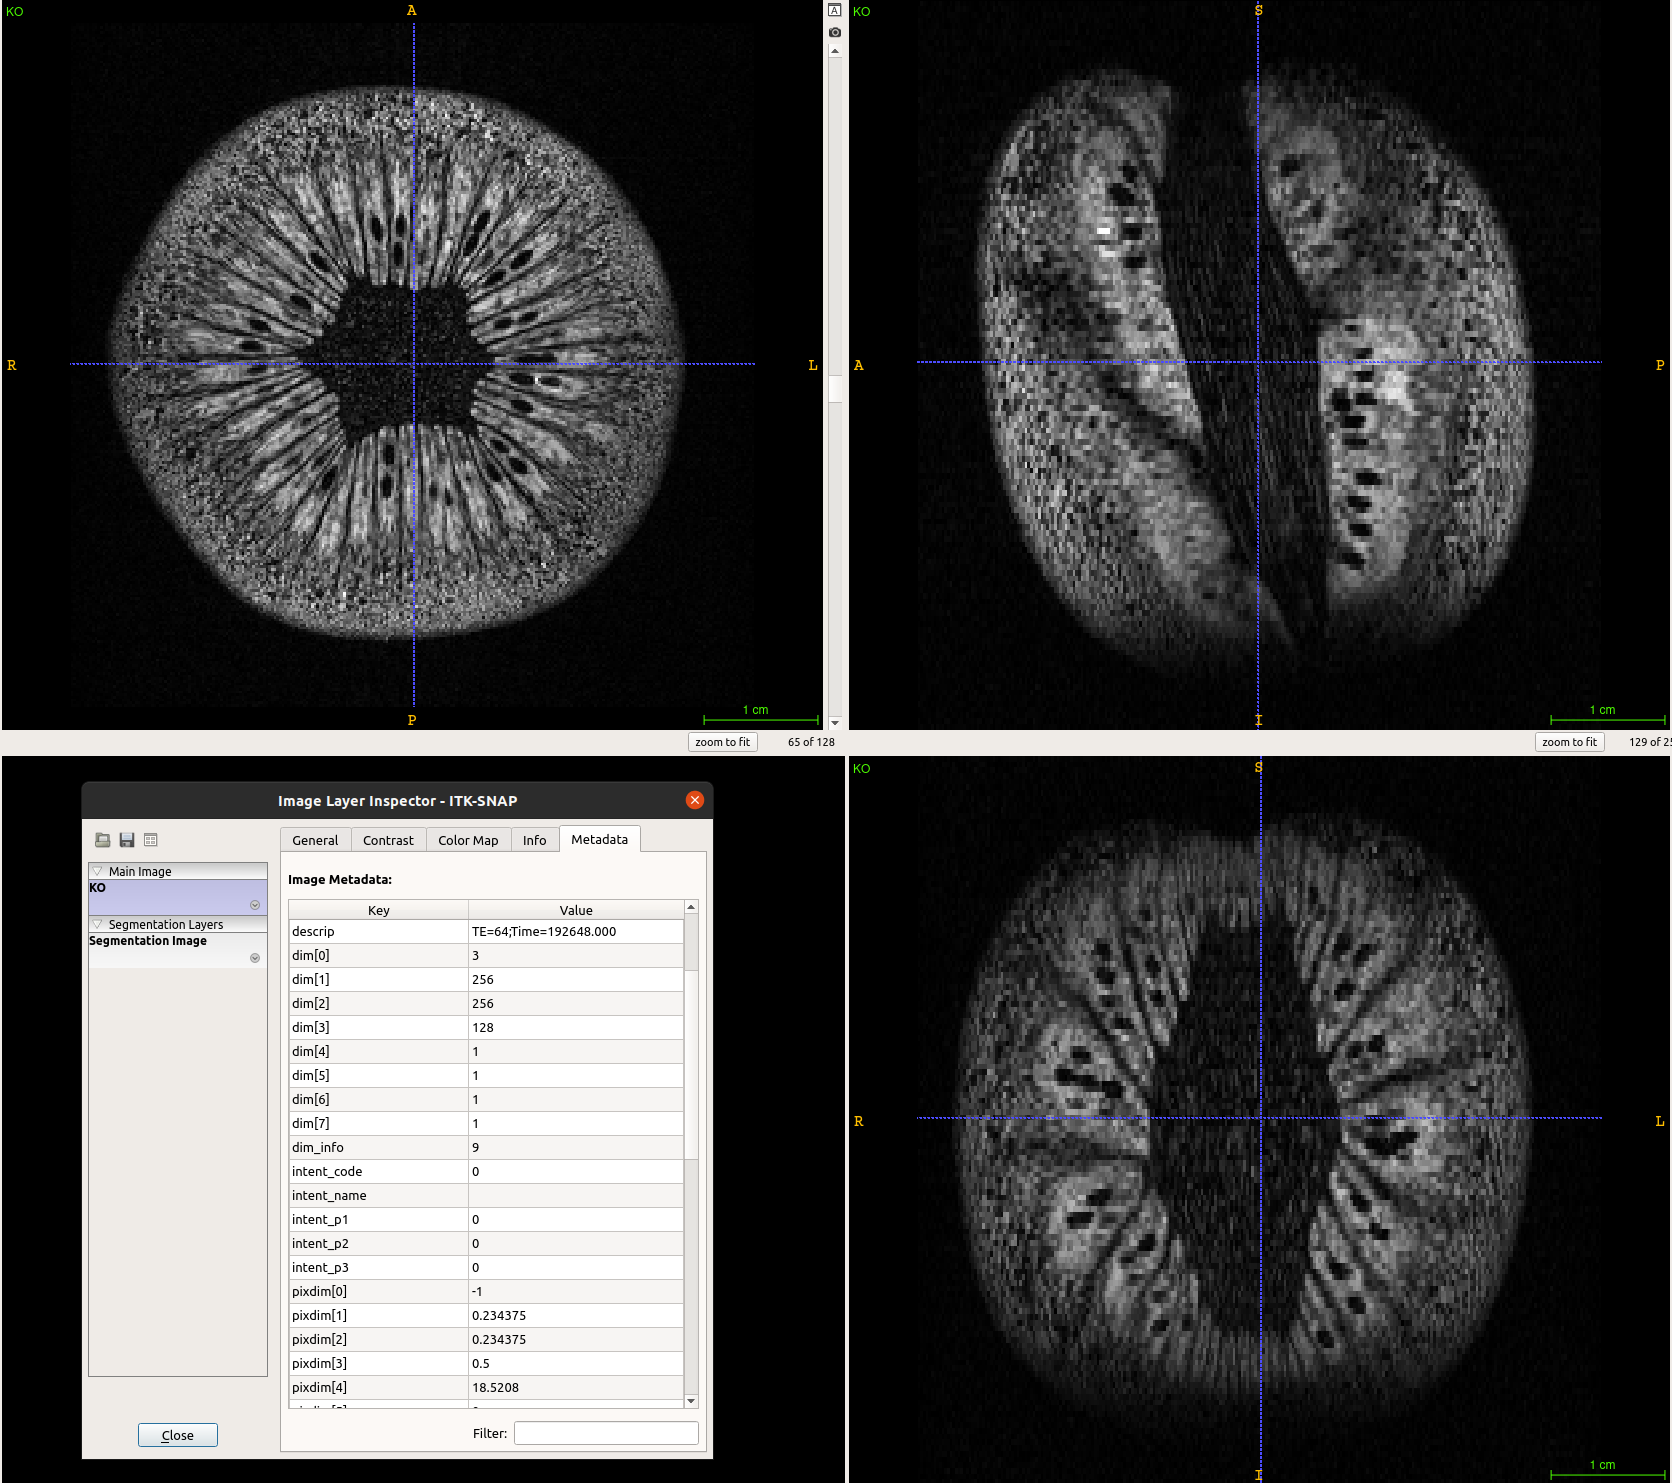

In [53]:
Image(filename='data/ko.png')

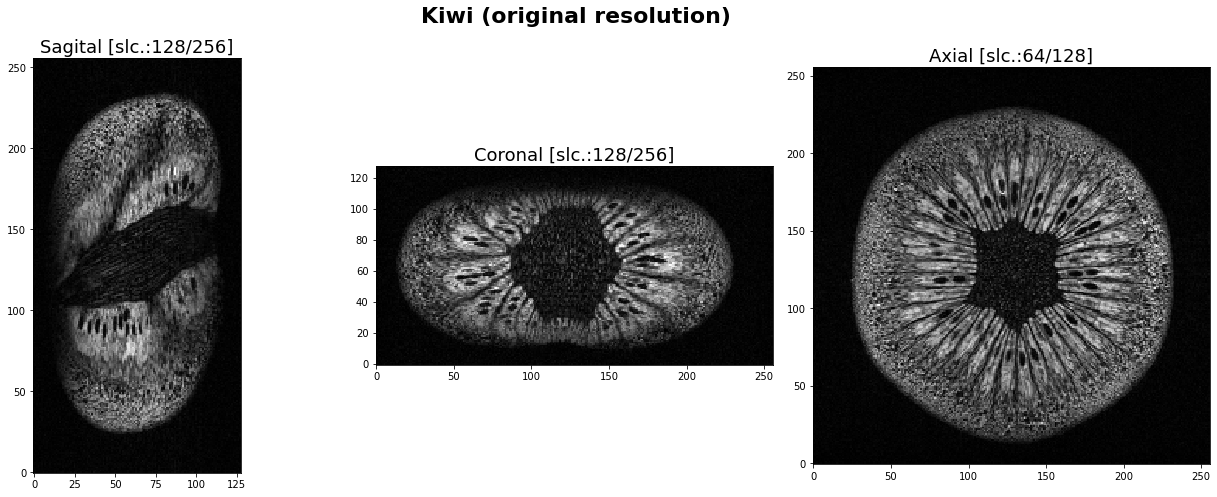

In [58]:
show_all_crossections(ko, type='S', title = 'Kiwi (original resolution)')

As there is only one 3D image, I wanted to treat some of 2D slices as traing set and the others as a test set. There is no image with labeled seeds that could serve as a ground truth, so I started to manyally label seads in each slices. For this purpose I used segmentation toolbox implemented in ITK-SNAP software. This is tedious and time consuming job. I marked manually each seed in the high-resolution section (let's call it axial). Even if I tried very hard (even with zooming some part of the image), the results are not satisfactory. There is a screen shot of the overlayed manual segmentation image to the kiwi image **below**. As we can see, high resoulion kiwi cut looks quite good, however in the low-resolution cuts we can see joined neighouring seeds. It seems that some of them are oversegmented. As we could expect, I've noticed that my decision on voxel classification is varying from day to day and relyes on my well-being. 

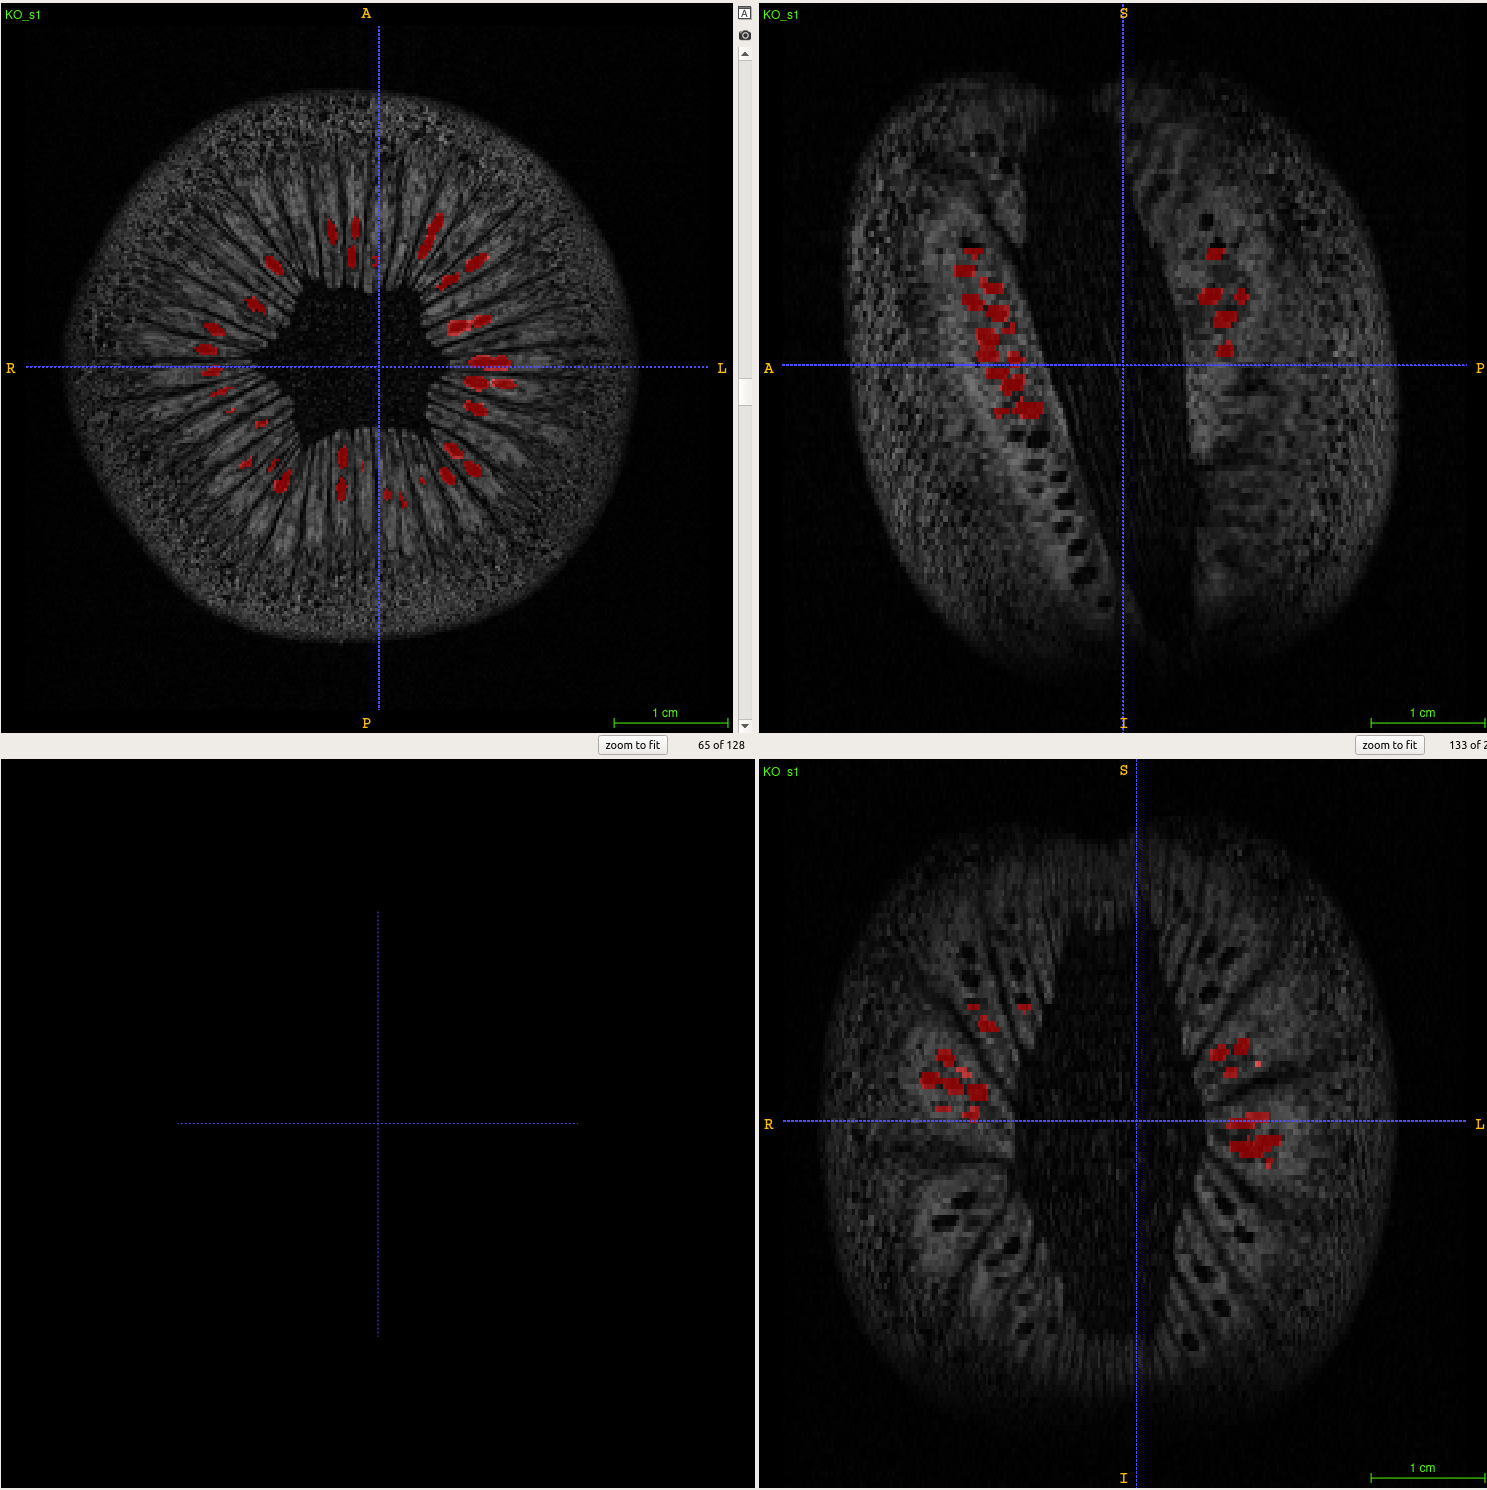

In [64]:
Image(filename='data/ko_manual_segmentation_overlay.png')

To get better look inside the segmentated image, I converted both images (ko and labeled one) to VTK file format and displayed them in `Paraview` software. To get a reference, I selected the axial cross section from kiwi image (ko.vtk). Manually labeled seeds were converted from image-voxel space to floating-point 3D space with the use of avaliable `Contour` filter. This operation created a surface of each seed. I used a default value of an isosurface (set to 1) in an built-in algorithm that converts 3D voxels into a triangle mesh (probaly `Marching Cube` algorithm is implemented behind the scene in this case). In the image (see **fig. below**) we can clearly see that the shape of seed surfaces is uneven, irregular and closer to cubic rather than to an oval one. Is is a concequence of big voxel dimensions in low-resolution direction compared to seed size. 

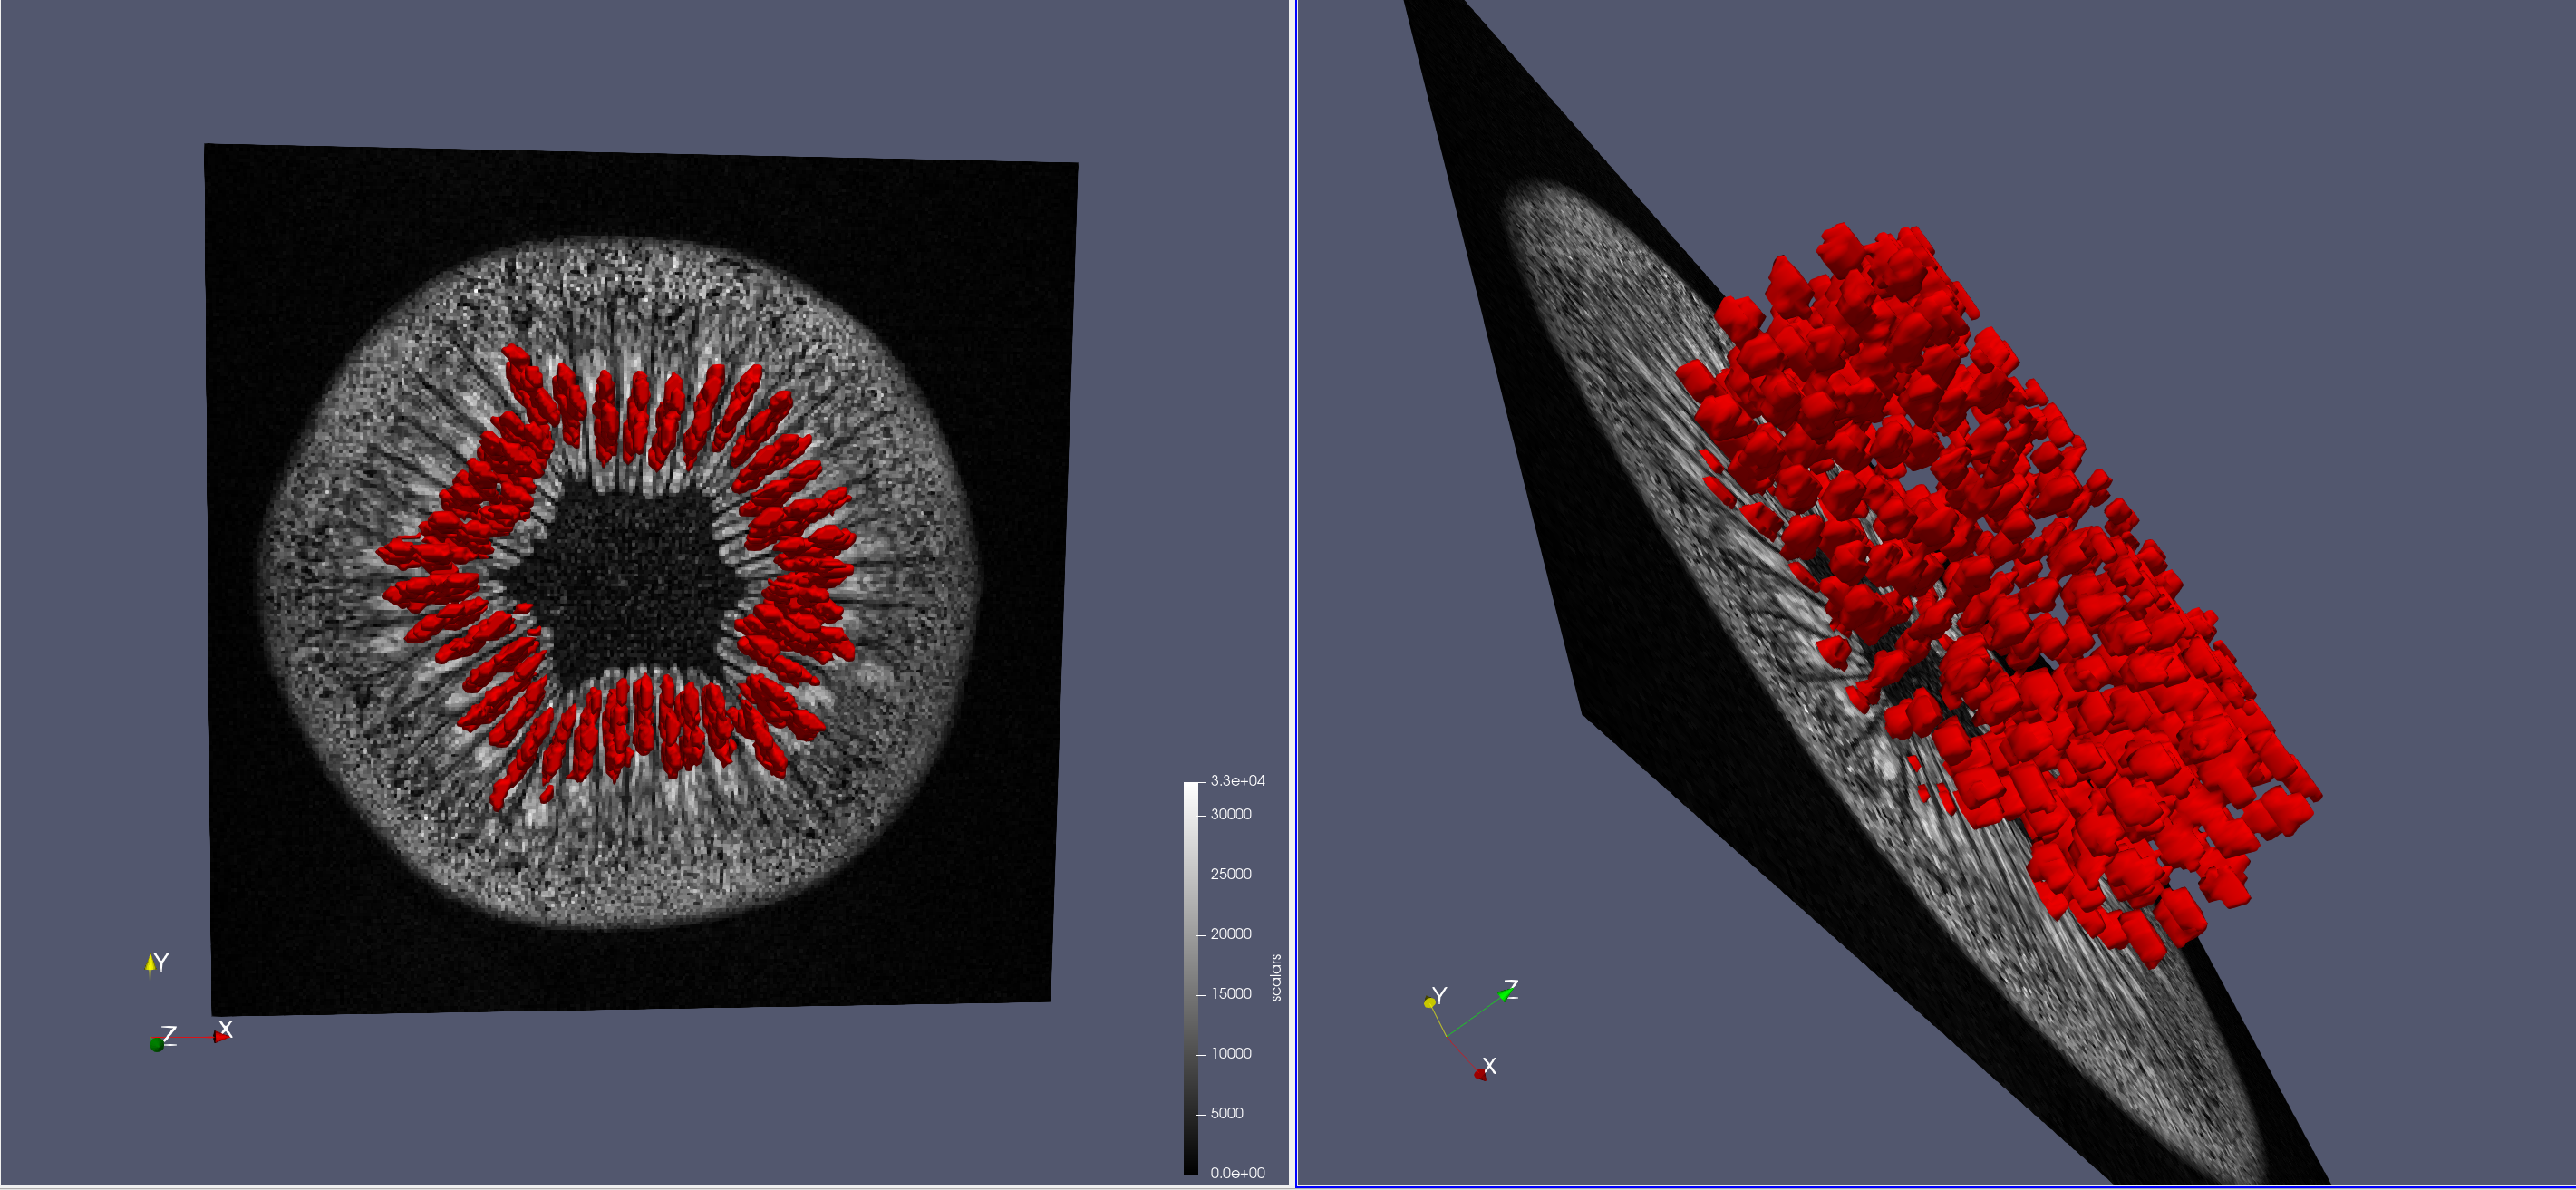

In [68]:
Image(filename='data/ko_manual_segmentation_paraview.png')

----

To solve this problem I resampled the image with anisotropic voxel size to the image in wich all voxel sides are equalled (isotripic) and their length is set to the length of the shortest voxel side in the anisotropic voxel, that is to 0.23 mm. For this purpose I used `c3d` software that uses bicubic interpolation to asses new voxel values. The new image was saved as `ki.nii.gz` NIFTI file. As we can see **below** it seems that the details (seeds) are more clearly visible. The new image has similar number of slices in each direction (258x258x288) and almost cubic voxel size (0.23x0.23x0.22 mm3).

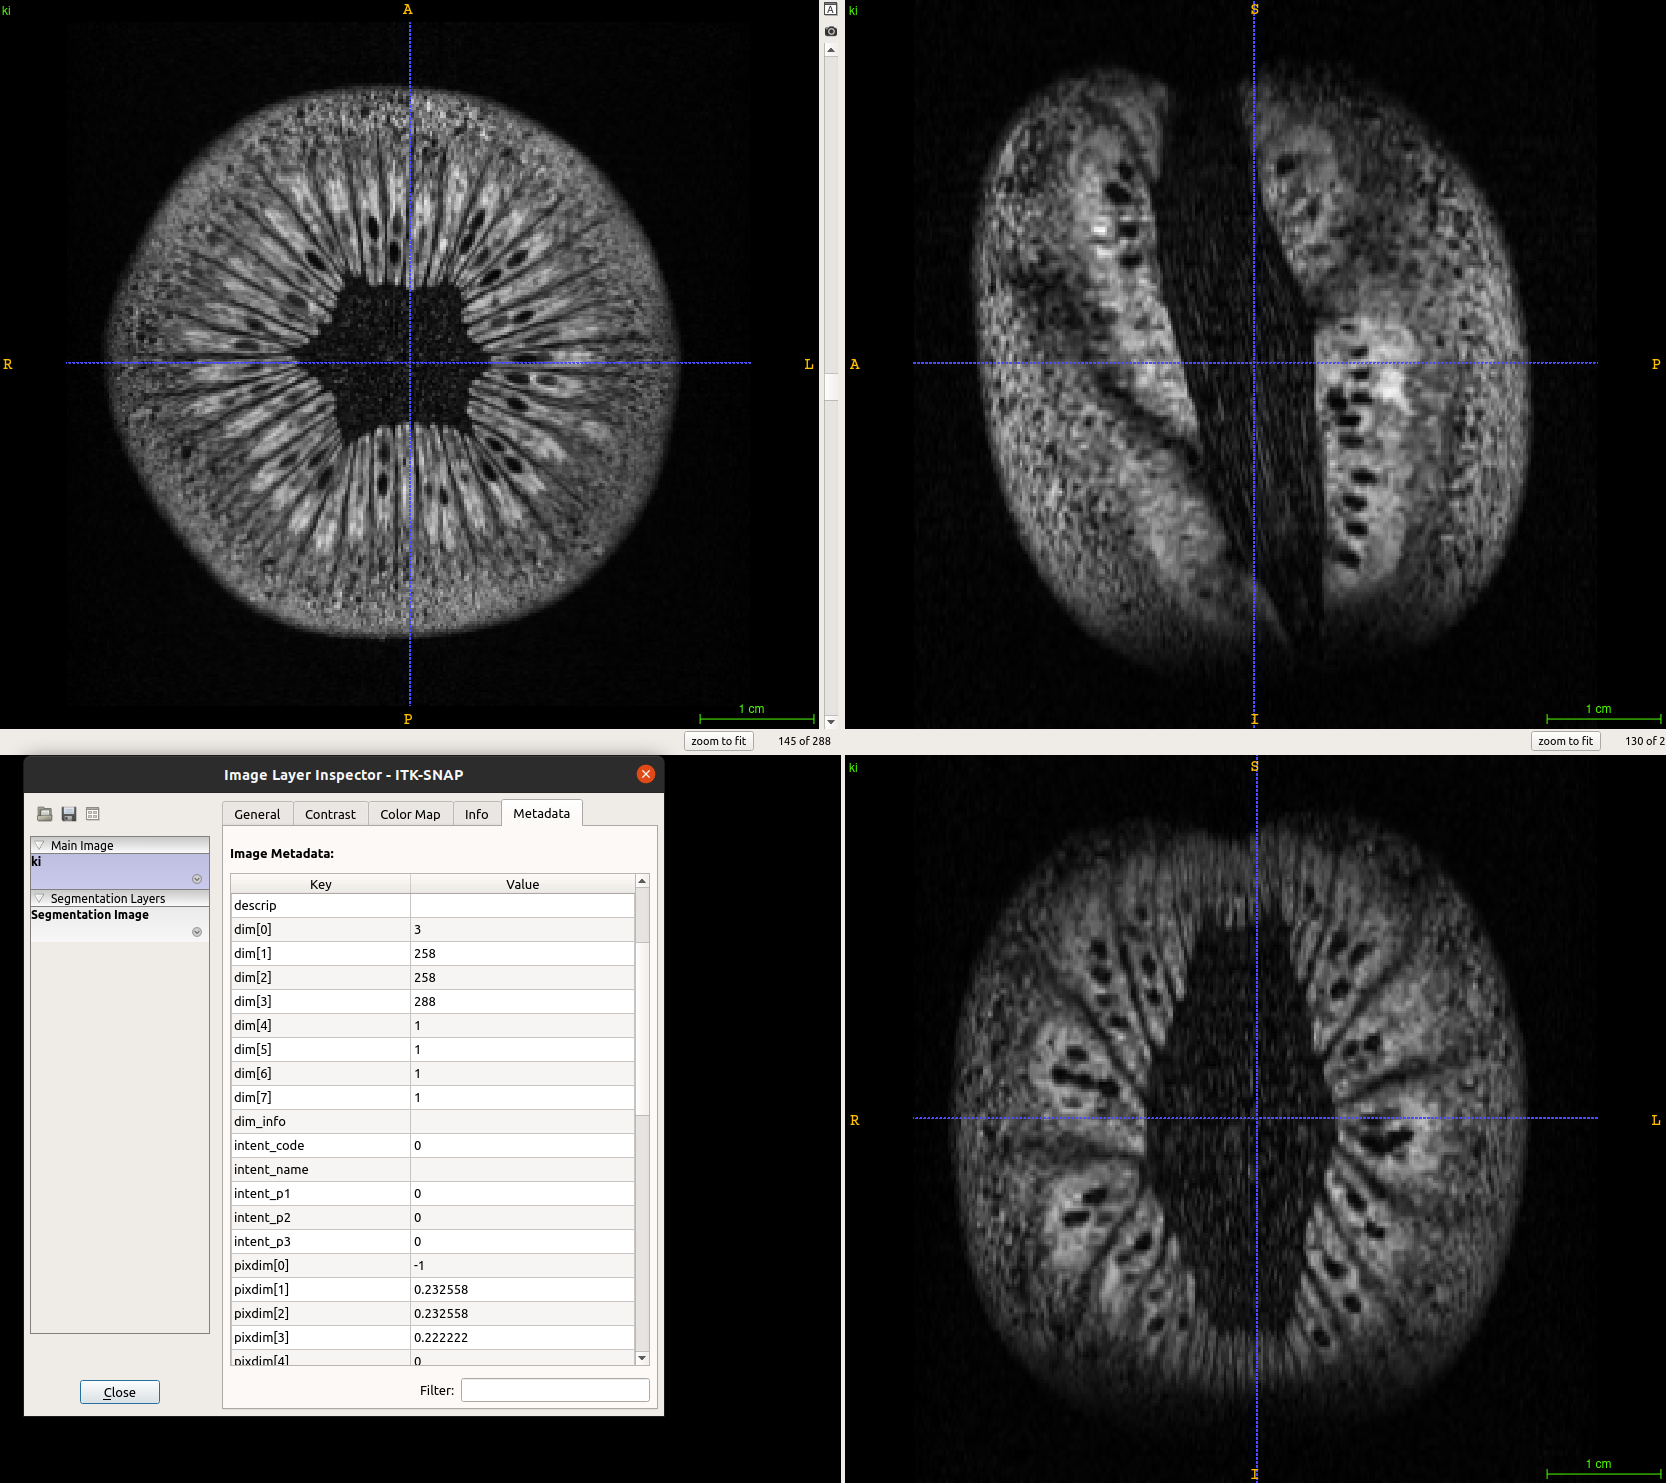

In [71]:
Image(filename='data/ki.png')

As we can see **below** even "simple" display of perpendicular cross sections, without taking into account voxel size, presents similar-size image in all directions. This is because all voxel side lengths are the (almost) equaled to each other.

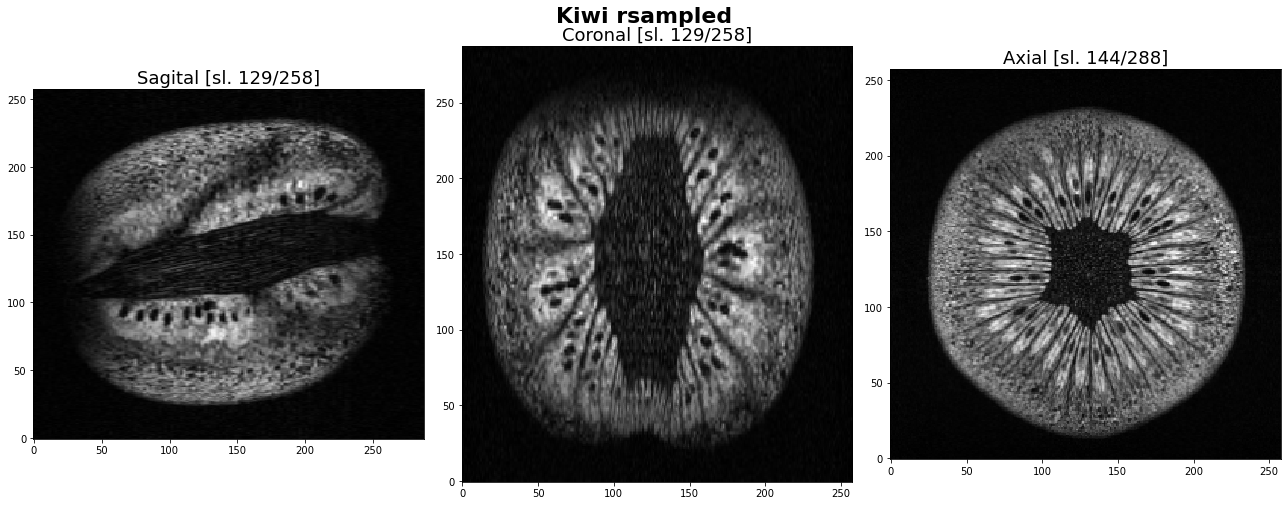

Resampled image:  max=30765.67, mean=3374.91, min=71.00, shape=(258, 258, 288)


In [79]:
ki_name = data / 'ki.nii.gz'
ki_nii = nib.load(ki_name)
ki = ki_nii.get_fdata()

show_all_crossections(ki, type='S', title = 'Kiwi rsampled')
info(ki, name='Resampled image')

Having resampled the main kiwi image, we would like to overlay previusly segmented images. However, in the current situation the resolutions of both images are inconsistent. It seems that the only option to fuse both images is to follow the same path and use `c3d` software to resample manually labeled data. it results in some additional issues that must be handled. Interpolaion

# THE GOAL:
## SEGMENT SEEDS WITH ITK-SNAP LEVEL-SET BUILT-IN FUNCTIONS

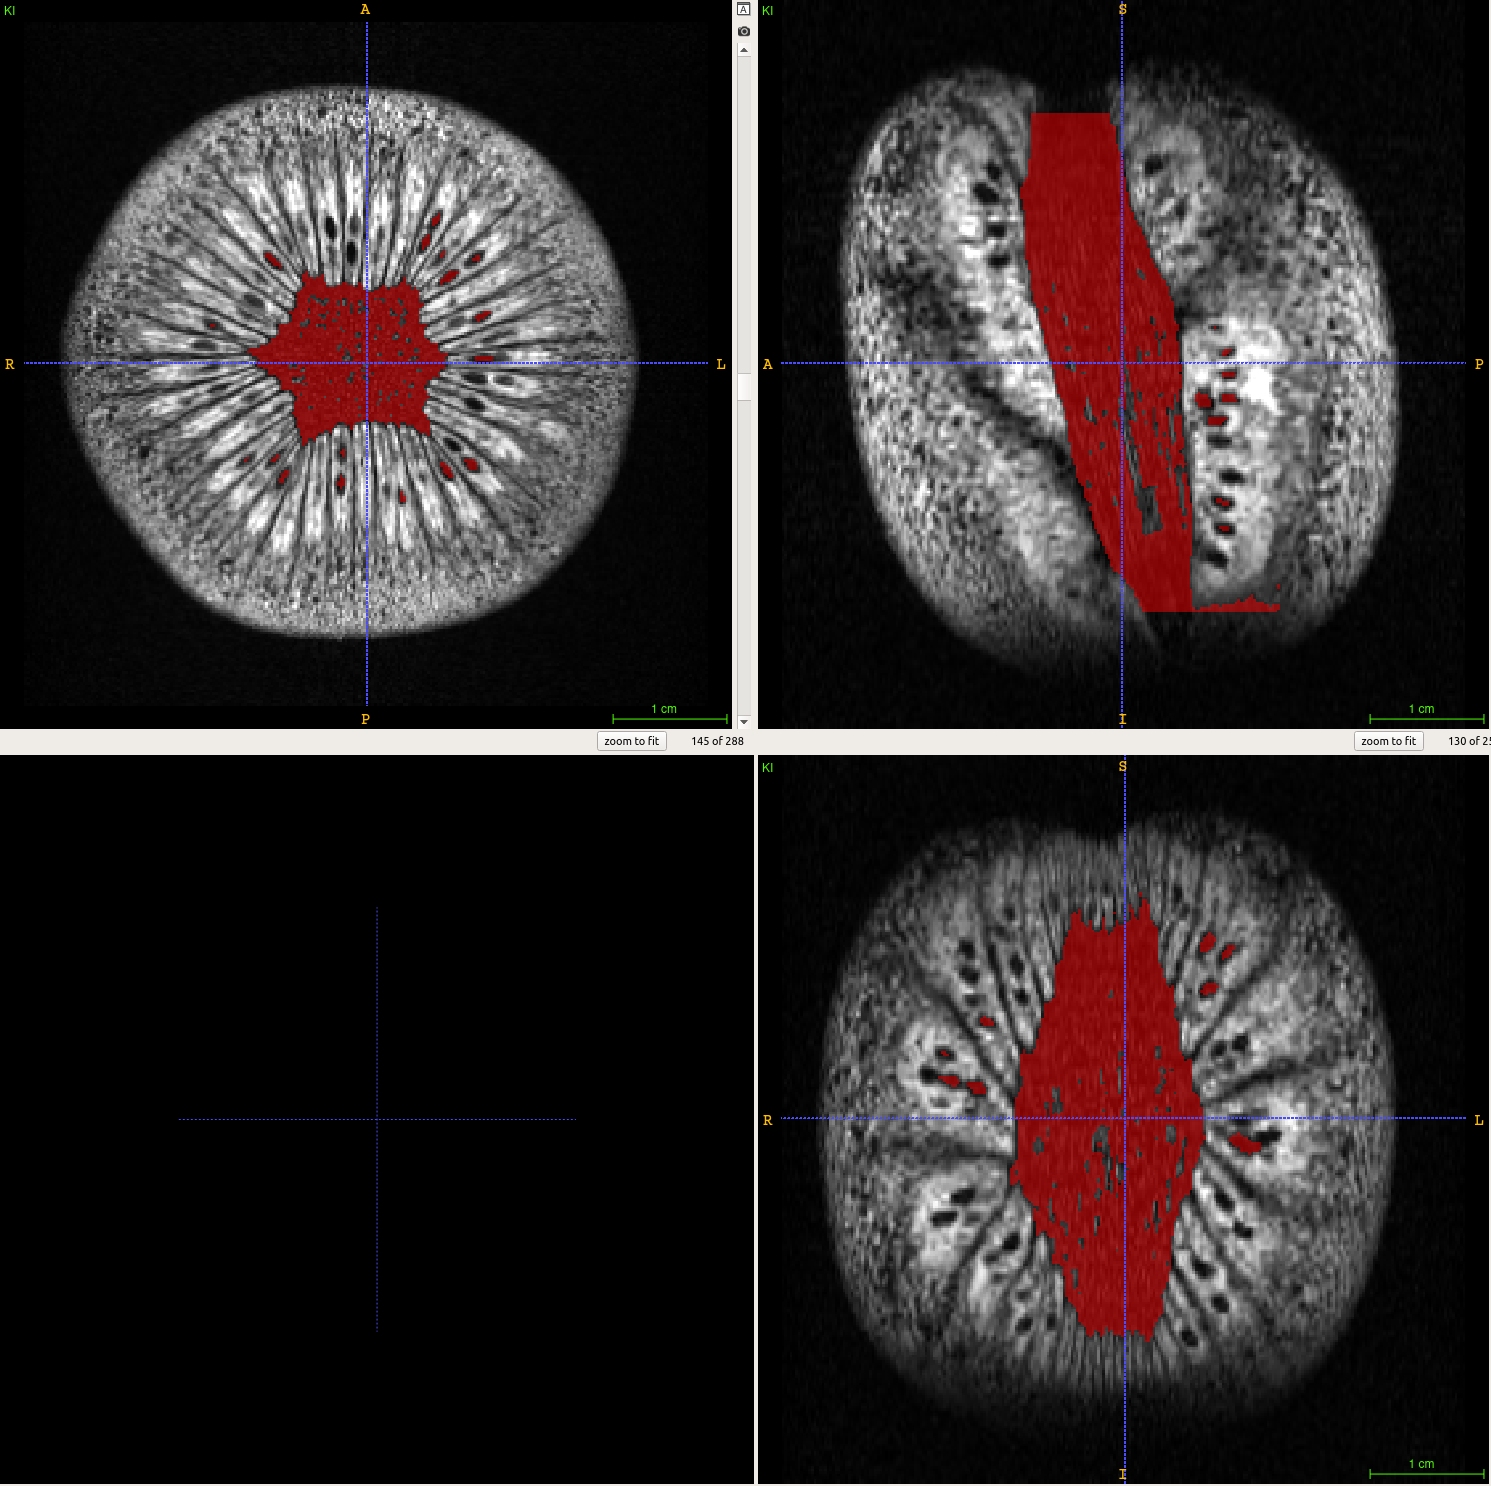

In [76]:
Image(filename='data/KI_LS_segm.png')

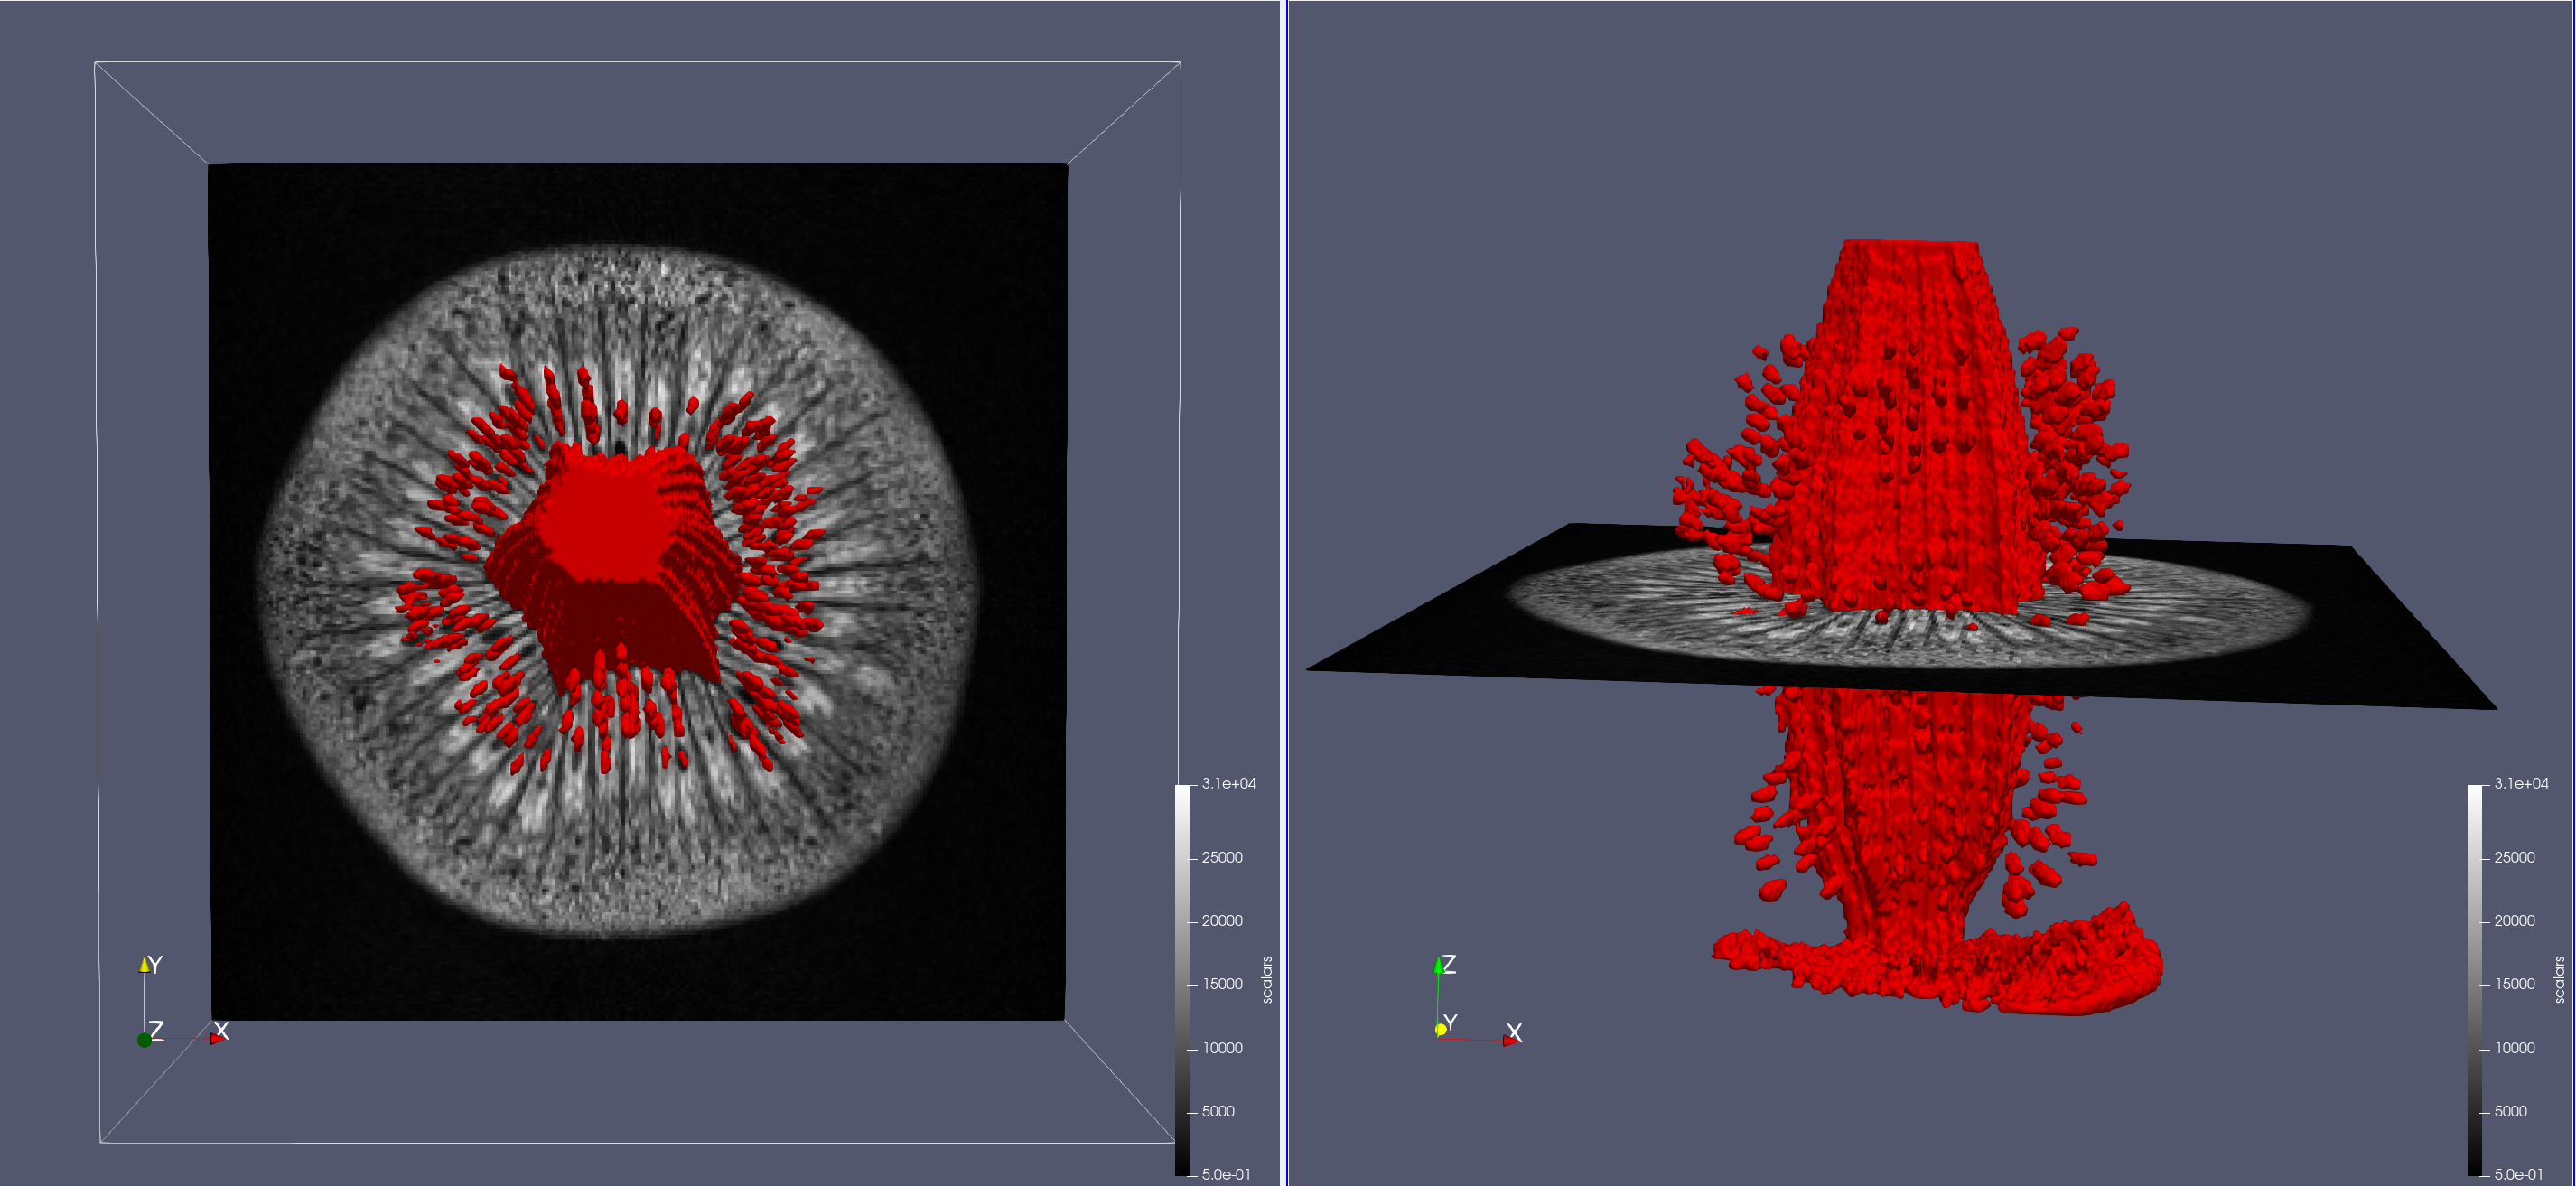

In [77]:
Image(filename='data/KI_LS_semg_paraview.png')

---

# GOAL: TO REMOVE BACKGROUND FROM ISOTROPIC IMAGE

### TASK1: USE A MEDIAN FILTER TO HIGHLIGHT THE FRUIT VOXELS

In [78]:
run_and_save_10 = False
name = f'kiwi_median_10.npy'

if run_and_save_10:
    ki_med10 = ndimage.median_filter(ki, size=size)
    np.save(data / name, ki_med10)
else:
    ki_med10 = np.load(data / name)

In [79]:
run_and_save_20 = False
name = 'kiwi_median_20.npy'

if run_and_save_20:
    ki_med20 = ndimage.median_filter(ki, size=20)
    np.save(data / name, ki_med20)
else:
    ki_med20 = np.load(data / name)

In [80]:
run_and_save_30 = False
name = 'kiwi_median_30.npy'

if run_and_save_30:
    ki_med30 = ndimage.median_filter(ki, size=30)
    np.save(data / name, ki_med30)
else:
    ki_med30 = np.load(data / name)

In [81]:
# show_all_crossections(ki_med10, type='S', title=f'KIWI - median filers kernel size: 10')
# info(ki_med10)

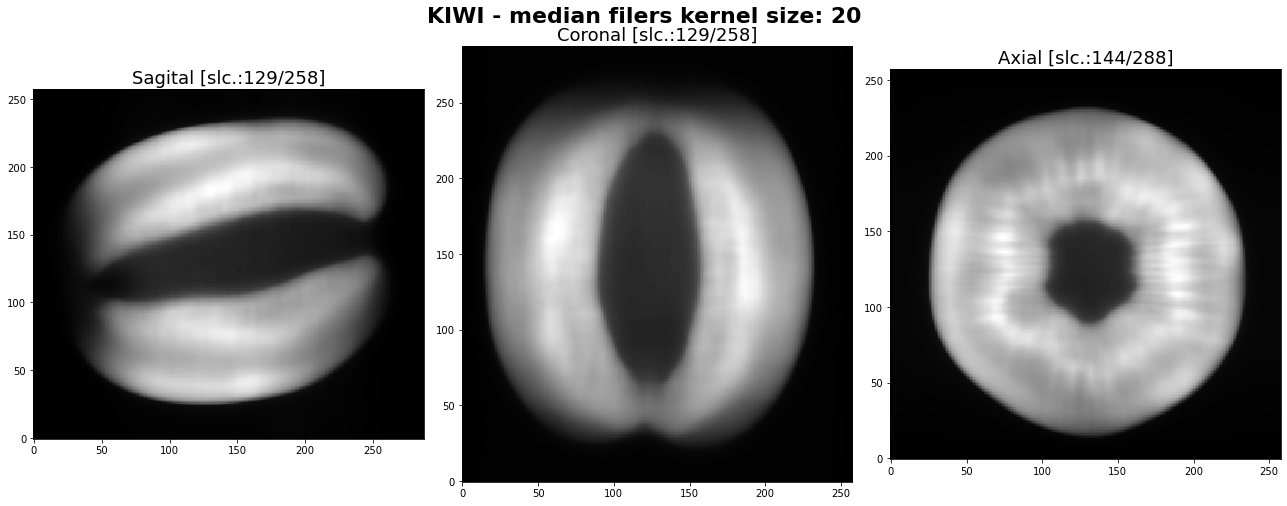

Kiwi:  max=15946.64, mean=3213.66, min=364.19, shape=(258, 258, 288)


In [82]:
show_all_crossections(ki_med20, type='S', title=f'KIWI - median filers kernel size: 20')
info(ki_med20)

In [83]:
# show_all_crossections(ki_med30, type='S', title=f'KIWI - median filers kernel size: 30')
# info(ki_med30)

In [84]:
if 0:
    ki_med10_nii = replace_data_nifti(ki_nii, ki_med10)
    ki_med10_nii.to_filename(data / 'ki_med10.nii.gz')
if 0:
    ki_med20_nii = replace_data_nifti(ki_nii, ki_med20)
    ki_med20_nii.to_filename(data / 'ki_med20.nii.gz')    
if 0:
    ki_med30_nii = replace_data_nifti(ki_nii, ki_med30)
    ki_med30_nii.to_filename(data / 'ki_med30.nii.gz')

---

### TASK 2: TO CREATE A FRUIT MASK (I.E. SEPARATE KIWI FROM BACKGROUND WITH A GLOBAL THRESHOLDING)

Experimentally selected threshodld value

In [85]:
image_2_th = ki_med20

rng1 = list(range(100, 2000,100)) 
th_data1 = np.zeros((len(rng1),2))
for k, t in enumerate(rng1):
    a = np.where(image_2_th >= t)[0]
    th_data1[k,:] = t,len(a) 

In [86]:
rng2 = list(range(2000, 16000,200))
th_data2 = np.zeros((len(rng2),2))
for k, t in enumerate(rng2):
    a = np.where(image_2_th >= t)[0]
    th_data2[k,:] = t,len(a) 

In [87]:
rng3 = list(range(100, 16000,200))
th_data3 = np.zeros((len(rng3),2))
for k, t in enumerate(rng3):
    a = np.where(image_2_th >= t)[0]
    th_data3[k,:] = t,len(a) 

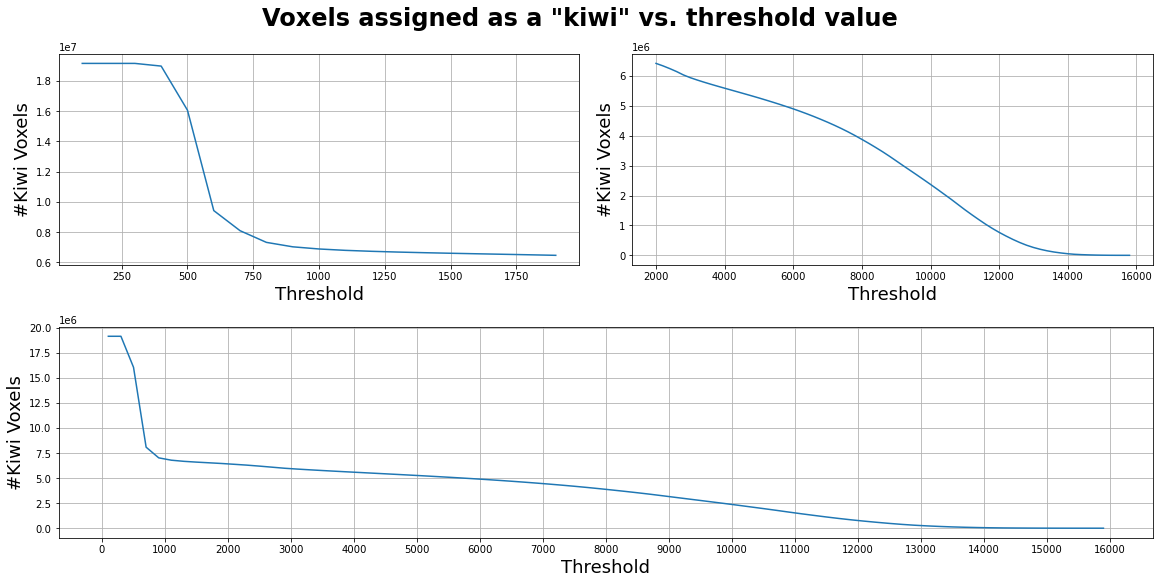

In [88]:
import matplotlib.gridspec as gridspec
fig2 = plt.figure(constrained_layout=True,figsize=(16,8))
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax2 = fig2.add_subplot(spec2[0, 1])
ax3 = fig2.add_subplot(spec2[1, :])

ax1.plot(th_data1[:,0], th_data1[:,1])
ax1.set_xlabel('Threshold', fontsize=18)
ax1.set_ylabel('#Kiwi Voxels', fontsize=18)
ax1.grid()


ax2.plot(th_data2[:,0], th_data2[:,1])
ax2.set_xlabel('Threshold', fontsize=18)
ax2.set_ylabel('#Kiwi Voxels', fontsize=18)
#ax2.set_title('Voxels in the fruit')
ax2.grid()

ax3.plot(th_data3[:,0], th_data3[:,1])
ax3.set_xlabel('Threshold', fontsize=18)
ax3.set_ylabel('#Kiwi Voxels', fontsize=18)
ax3.set_xticks(np.arange(0,16500,1000))
ax3.grid()


_ = plt.suptitle('Voxels assigned as a "kiwi" vs. threshold value', fontsize=24, weight='bold')
plt.ticklabel_format(axis="y", style="sci", scilimits=(6,6))
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0), )

---

In [89]:
image_2_th = ki_med20
th450 = np.where(image_2_th >= 450, 1, 0)
th550 = np.where(image_2_th >= 550, 1, 0)
th750 = np.where(image_2_th >= 750, 1, 0)
th1000 = np.where(image_2_th >= 1000, 1, 0)
th4500 = np.where(image_2_th >= 4500, 1, 0)
th5500 = np.where(image_2_th >= 5500, 1, 0)

In [90]:
diff = th4500 - th5500

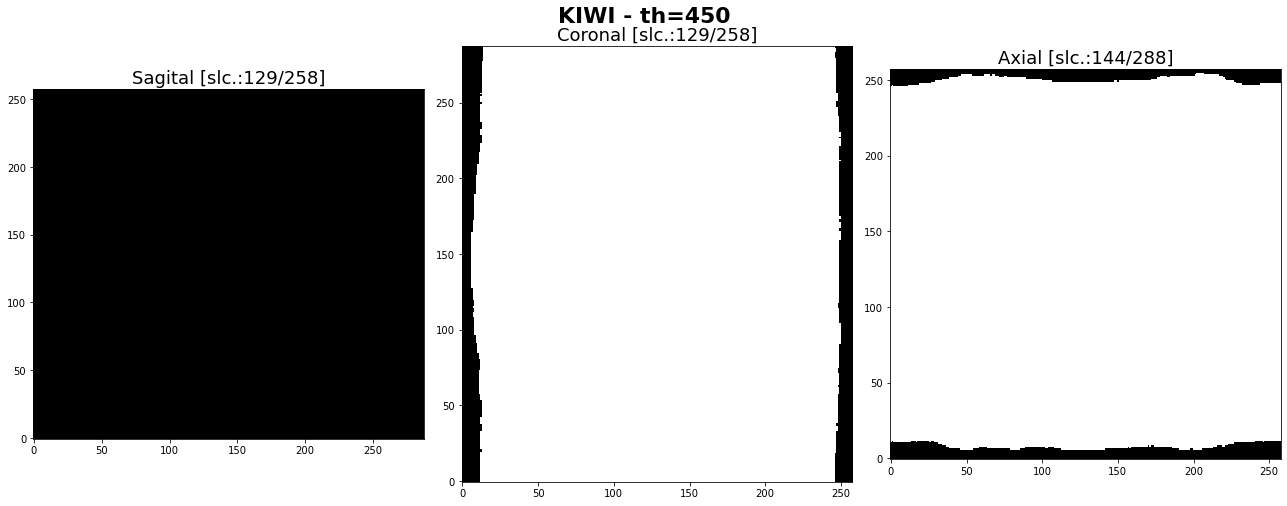

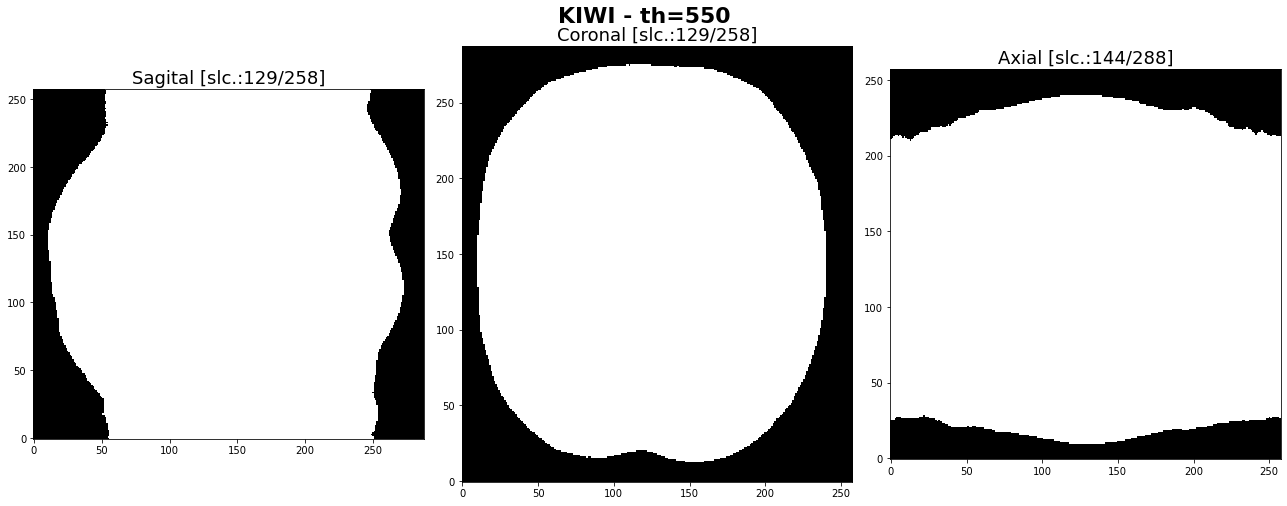

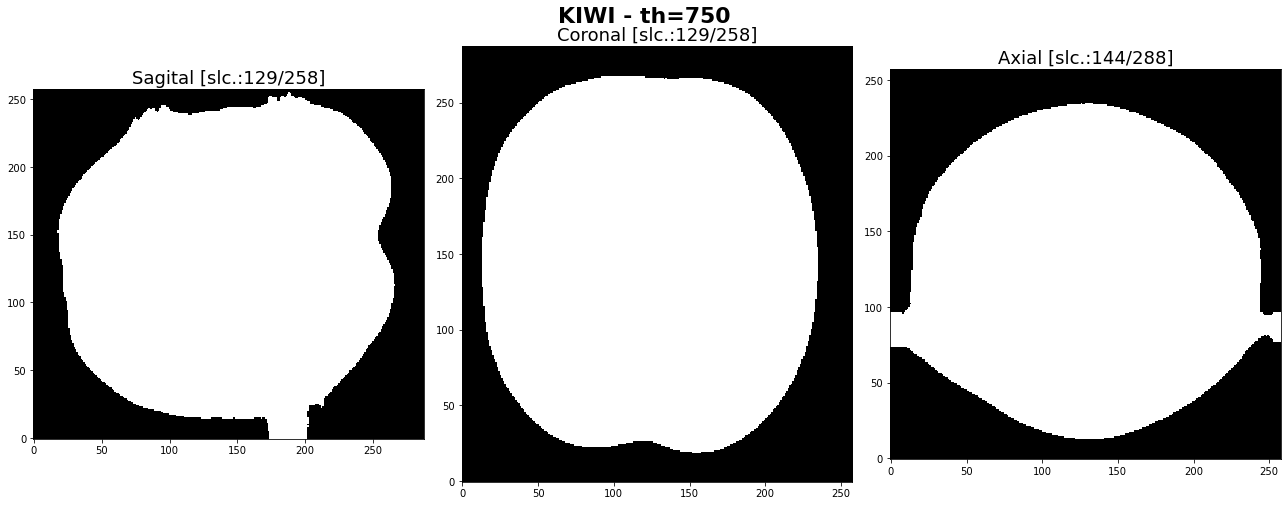

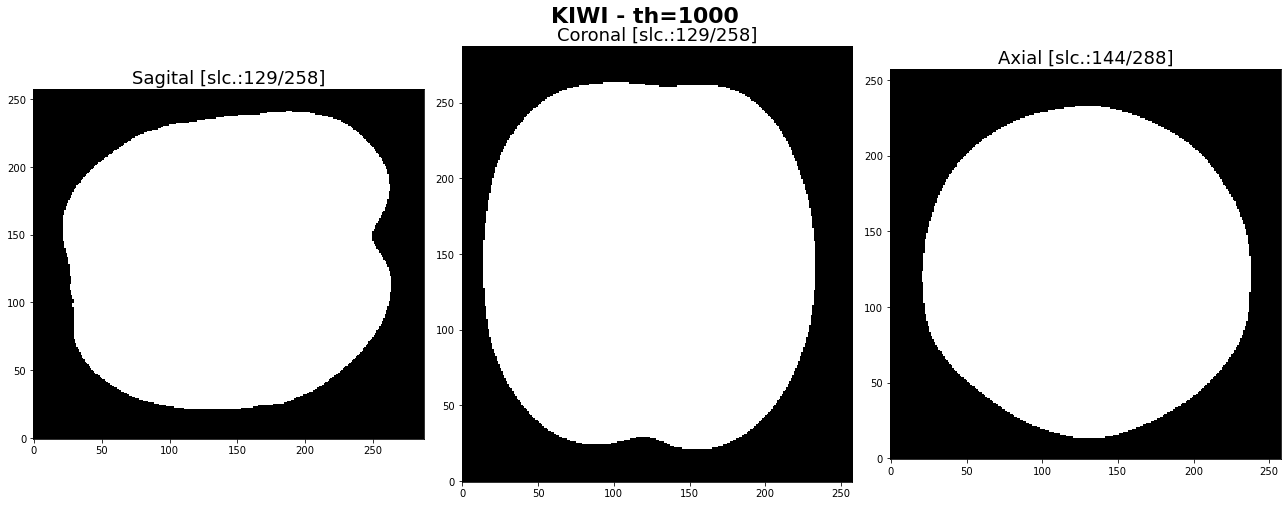

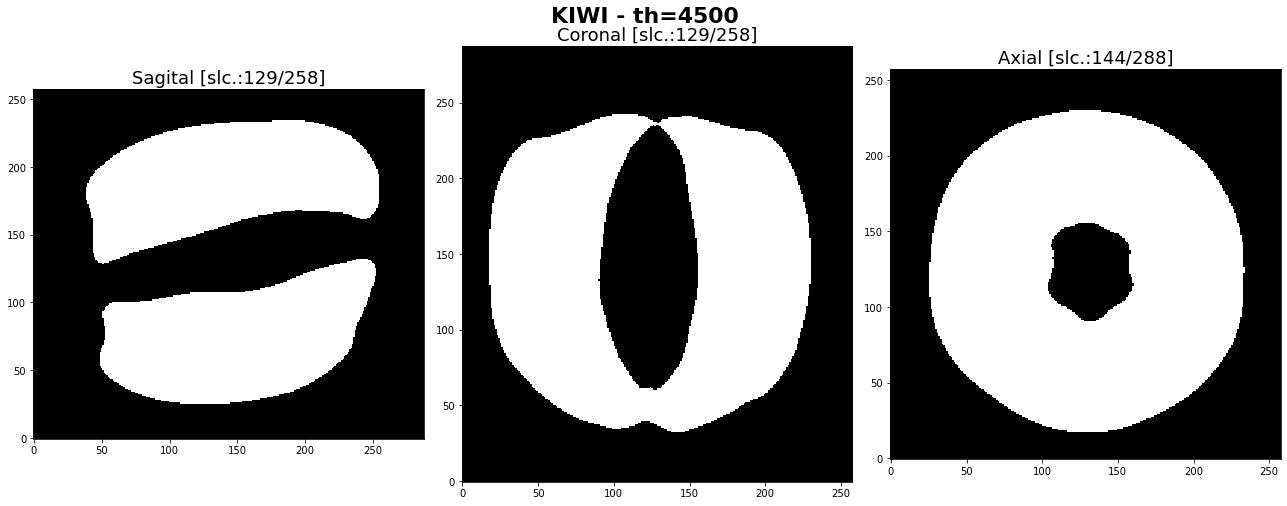

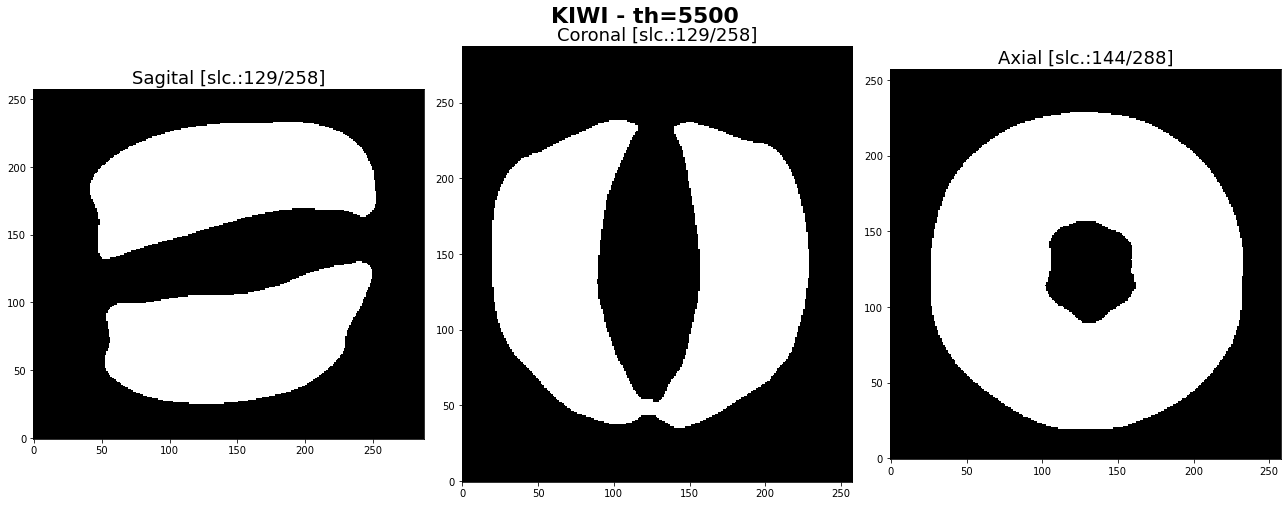

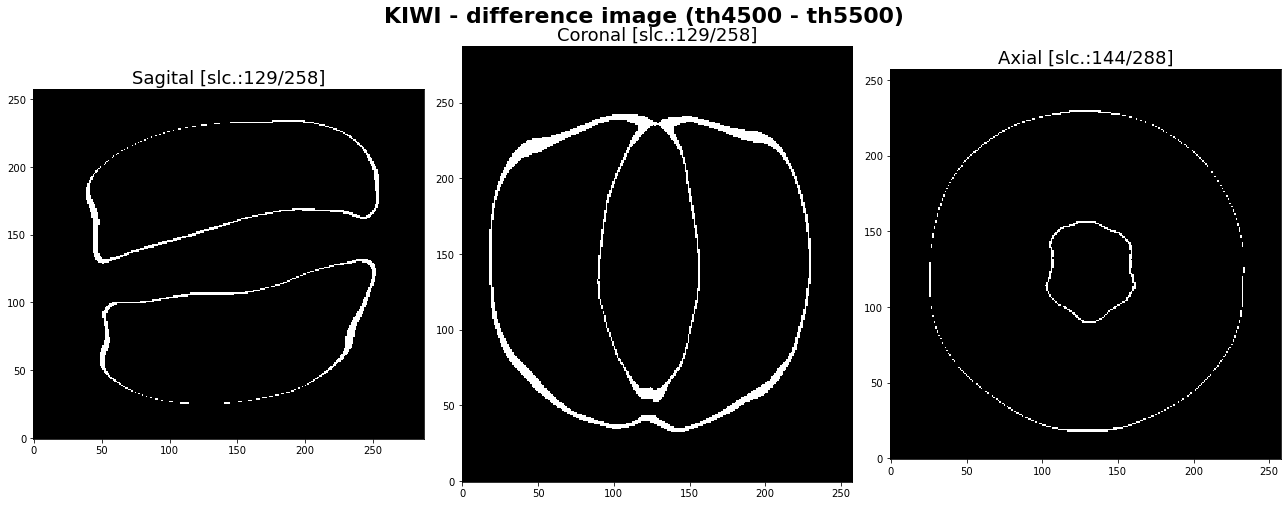

In [91]:
show_all_crossections(th450, type='S', title='KIWI - th=450')
show_all_crossections(th550, type='S', title='KIWI - th=550')
show_all_crossections(th750, type='S', title='KIWI - th=750')
show_all_crossections(th1000, type='S', title='KIWI - th=1000')
show_all_crossections(th4500, type='S', title='KIWI - th=4500')
show_all_crossections(th5500, type='S', title='KIWI - th=5500')
show_all_crossections(diff, type='S', title='KIWI - difference image (th4500 - th5500)')

### TASK3: CREATE A MASK FOT THRESHODL = 4500 (TO SEPARATE THE FRUIT FROM BACKGROUND)

In [92]:
choice_array = th4500
ki_foreground = np.choose(choice_array, (0,ki))

In [93]:
if 0:
    ki_foreground_nii = replace_data_nifti(ki_nii, ki_foreground)
    ki_foreground_nii.to_filename(data / 'ki_foreground.nii.gz')

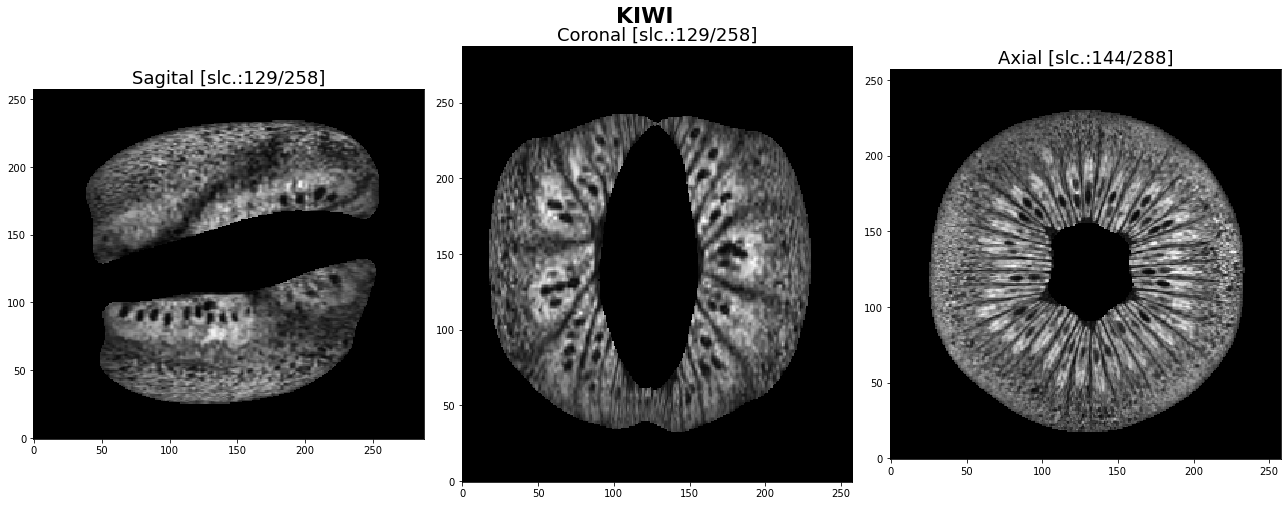

Kiwi:  max=30765.67, mean=2801.80, min=0.00, shape=(258, 258, 288)


In [94]:
show_all_crossections(ki_foreground, type='S')
info(ki_foreground)

### TASK 4: REMOVE DART PERPENDICULAR STRUCTURES FROM THE IMAGE

### USE MULTISCALLE VESSEL-ENHANCEMENT FILTER

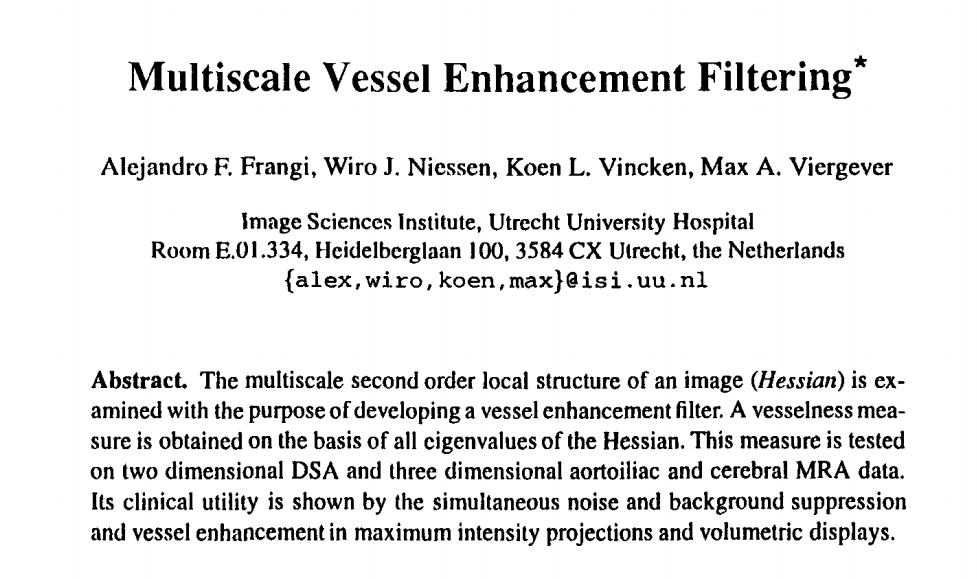

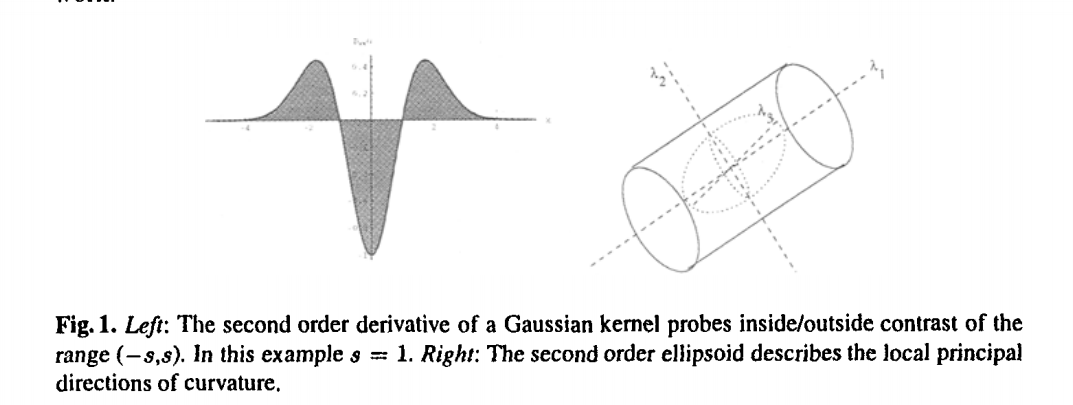

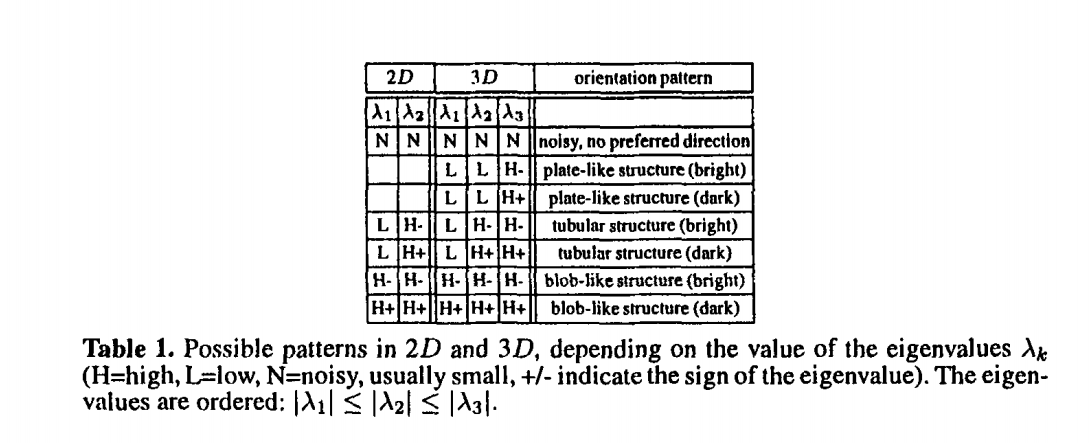

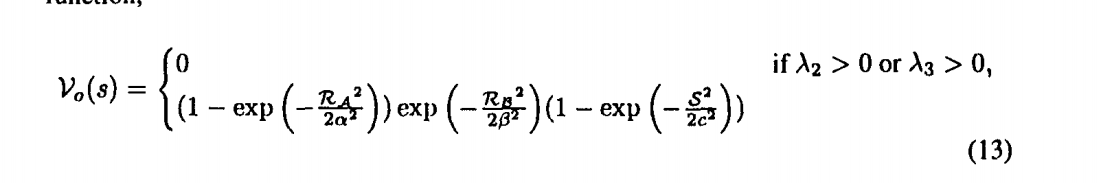

In [95]:
display(Image(filename='data/frangi_1.png'))
display(Image(filename='data/frangi_2.png'))
display(Image(filename='data/frangi_3.png'))
display(Image(filename='data/frangi_4.png'))

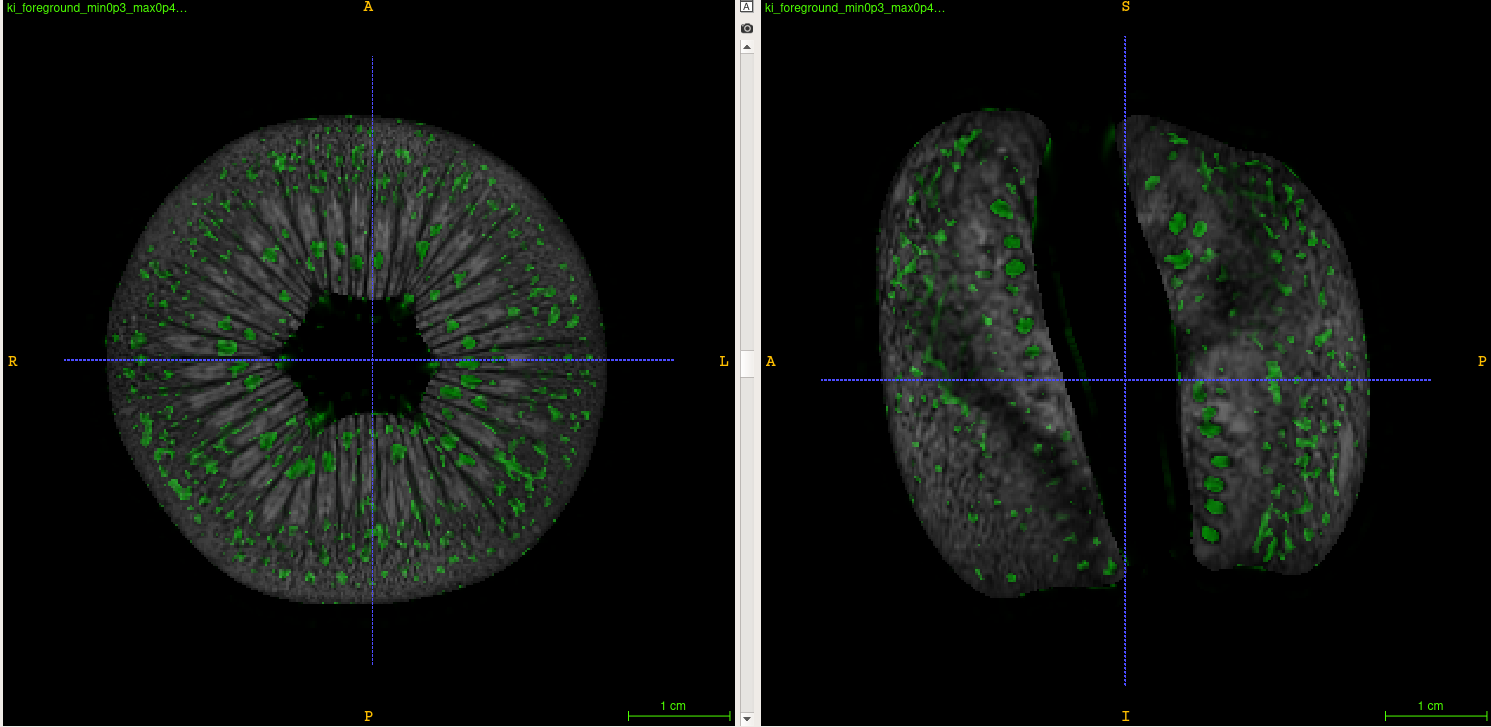

In [96]:
Image(filename='data/ki_foreground_min3-max4.png')

### TASK 5: TO SEPARATE RIGIONS WITH SEEDS

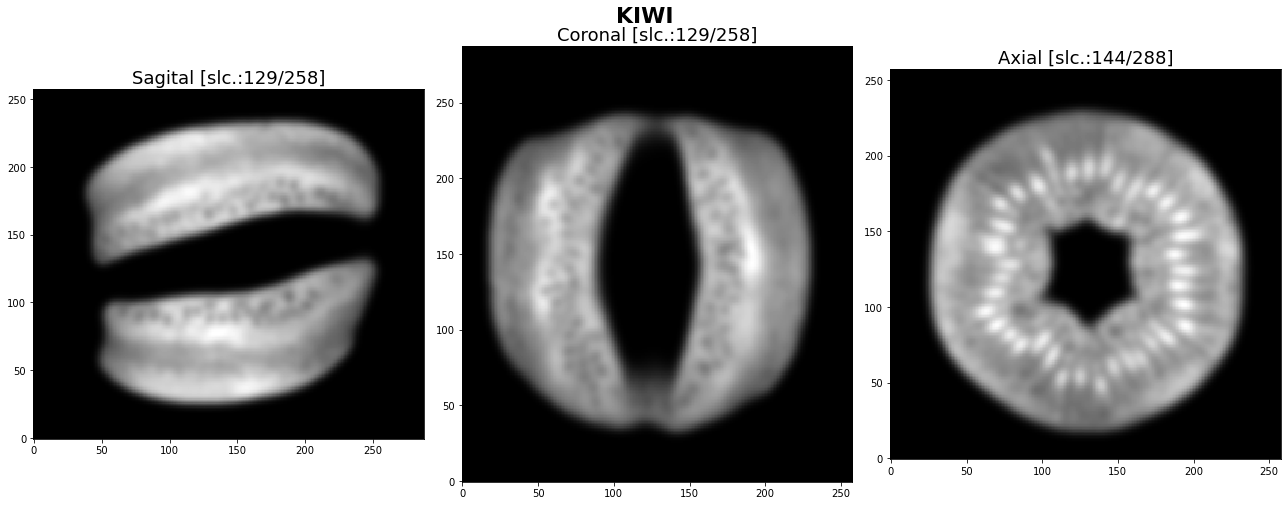

Kiwi:  max=19365.46, mean=2801.80, min=0.00, shape=(258, 258, 288)


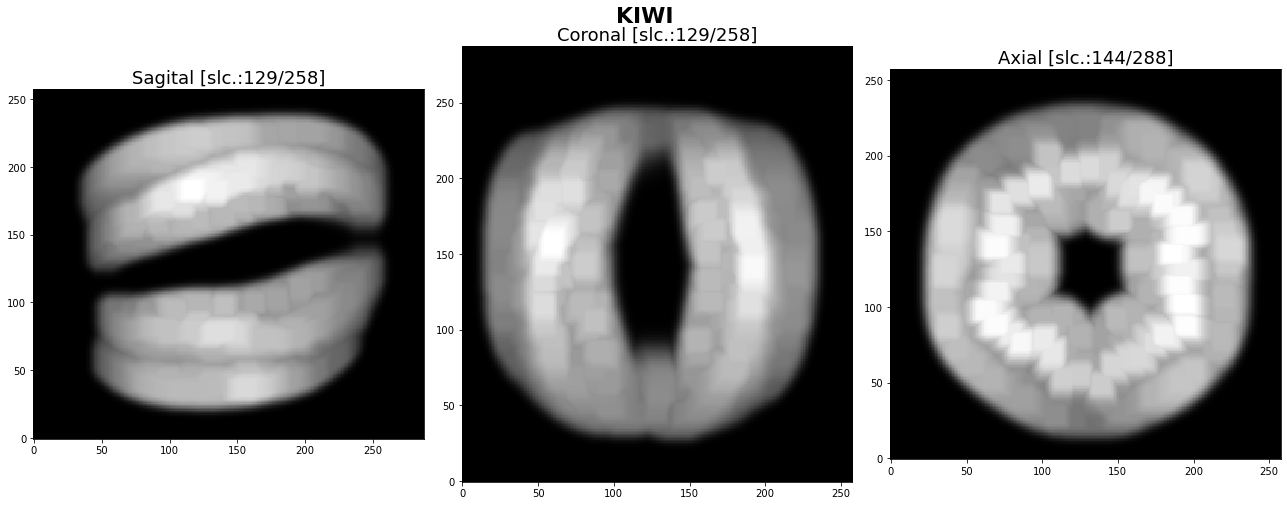

Kiwi:  max=19365.46, mean=3850.57, min=0.00, shape=(258, 258, 288)


In [97]:
tmp1 = ndimage.gaussian_filter(ki_foreground, sigma=3)
tmp2 = ndimage.maximum_filter(tmp1, size=10)

show_all_crossections(tmp1, type='S')
info(tmp1)
show_all_crossections(tmp2, type='S')
info(tmp2)

del tmp1, tmp2

### AN OBSTACLE: BRIGHTNESS INHOMOGENITY

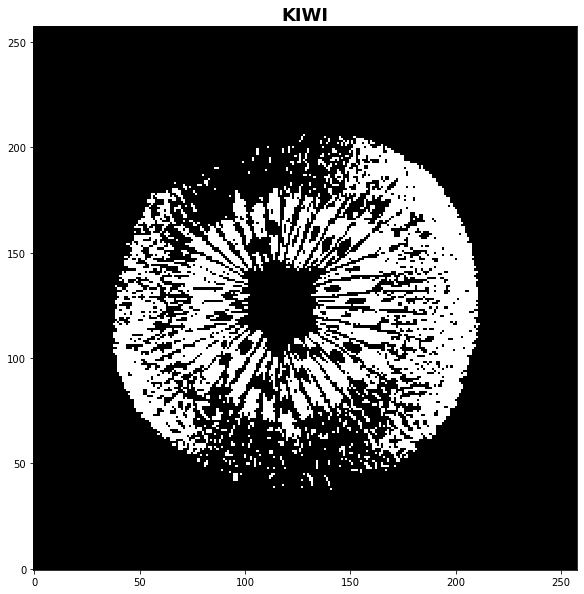

In [98]:
show_crossection(np.where(ki>7500, 1,0),type='S', dir=2)

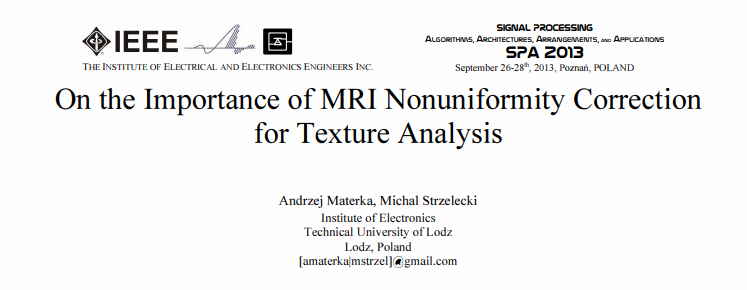

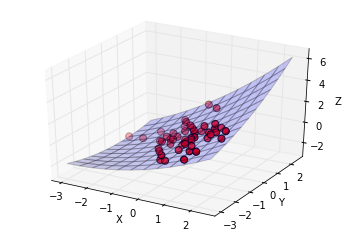

In [99]:
display(Image(filename='data/am_paper.png', width=800))
display(Image(filename='data/dopasowanie_powierzchni.png',width=1000))

[GitHub: amroamroamro](https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6)

### MANUAL ROI SELECTION

In [100]:
lx, ly, lz = ki_foreground.shape
ki_tube = ki_foreground.copy()

X, Y = np.ogrid[0:lx, 0:ly]
r = 80
mask = (X - lx//2)**2 + (Y - ly//2)**2 > r**2
for l in range(lz):
    ki_tube[mask, l] = 0

In [101]:
if 0:
    ki_tube_nii = replace_data_nifti(ki_nii, ki_tube)
    ki_tube_nii.to_filename(data / 'ki_tube.nii.gz')

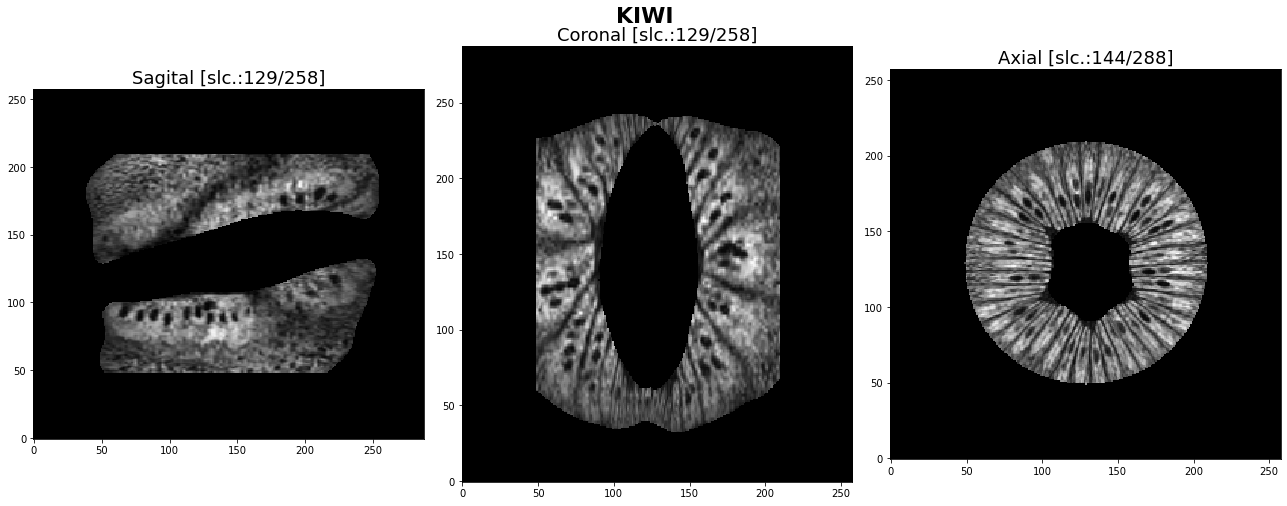

Kiwi:  max=30765.67, mean=1807.65, min=0.00, shape=(258, 258, 288)


In [104]:
show_all_crossections(ki_tube, type='S')
info(ki_tube)

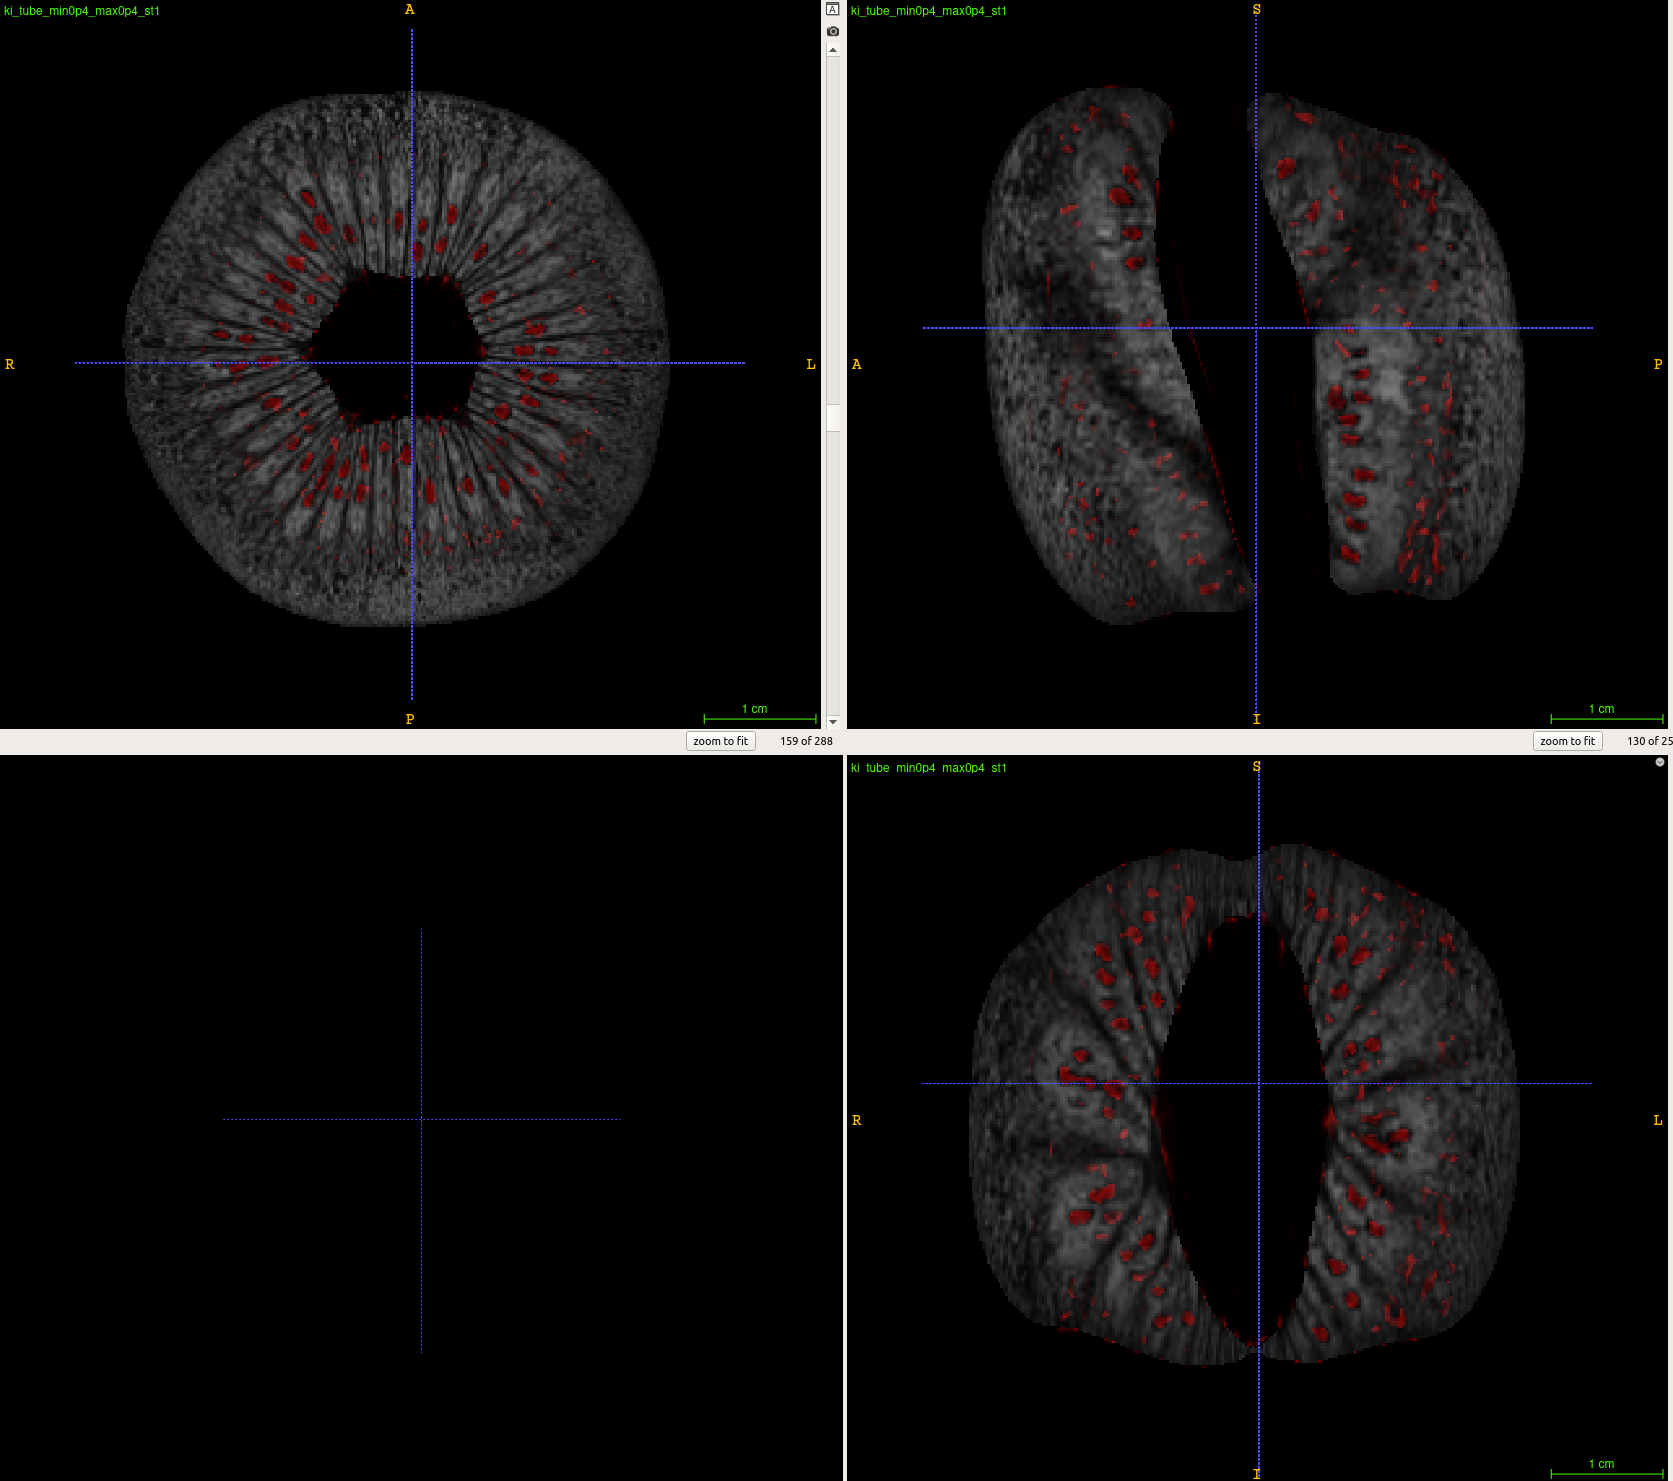

In [108]:
Image(filename='data/ki_tube_min4_max4.png')

### TASK 6: TO REMOVE SMALL SEGMENTED OBJECTS (E.G. SINGLE VOXELS)
### TOOL: MATHEMATICAL MORPHOLOGY OPERATIONS - BINARY EROSION & OPENING

#### Load seeds image

In [109]:
seeds_o = nib.load('data/ki_tube_min0p4_max0p4_st1.nii.gz').get_fdata()

In [110]:
seeds=seeds_o*ki_tube

In [111]:
struct = ndimage.generate_binary_structure(3, 1)
struct.shape

(3, 3, 3)

In [112]:
seeds = ndimage.binary_erosion(seeds, structure=struct)
seeds_res = ndimage.binary_opening(seeds,structure=struct)

In [116]:
# show_all_crossections(seeds_res, type='S')
# info(seeds_res)

In [114]:
if 0:
    seeds_res = seeds_res.astype(ko.dtype)
    ki_seeds_res_nii = replace_data_nifti(ki_nii, seeds_res)
    ki_seeds_res_nii.to_filename(data / 'ki_seeds_res.nii.gz')

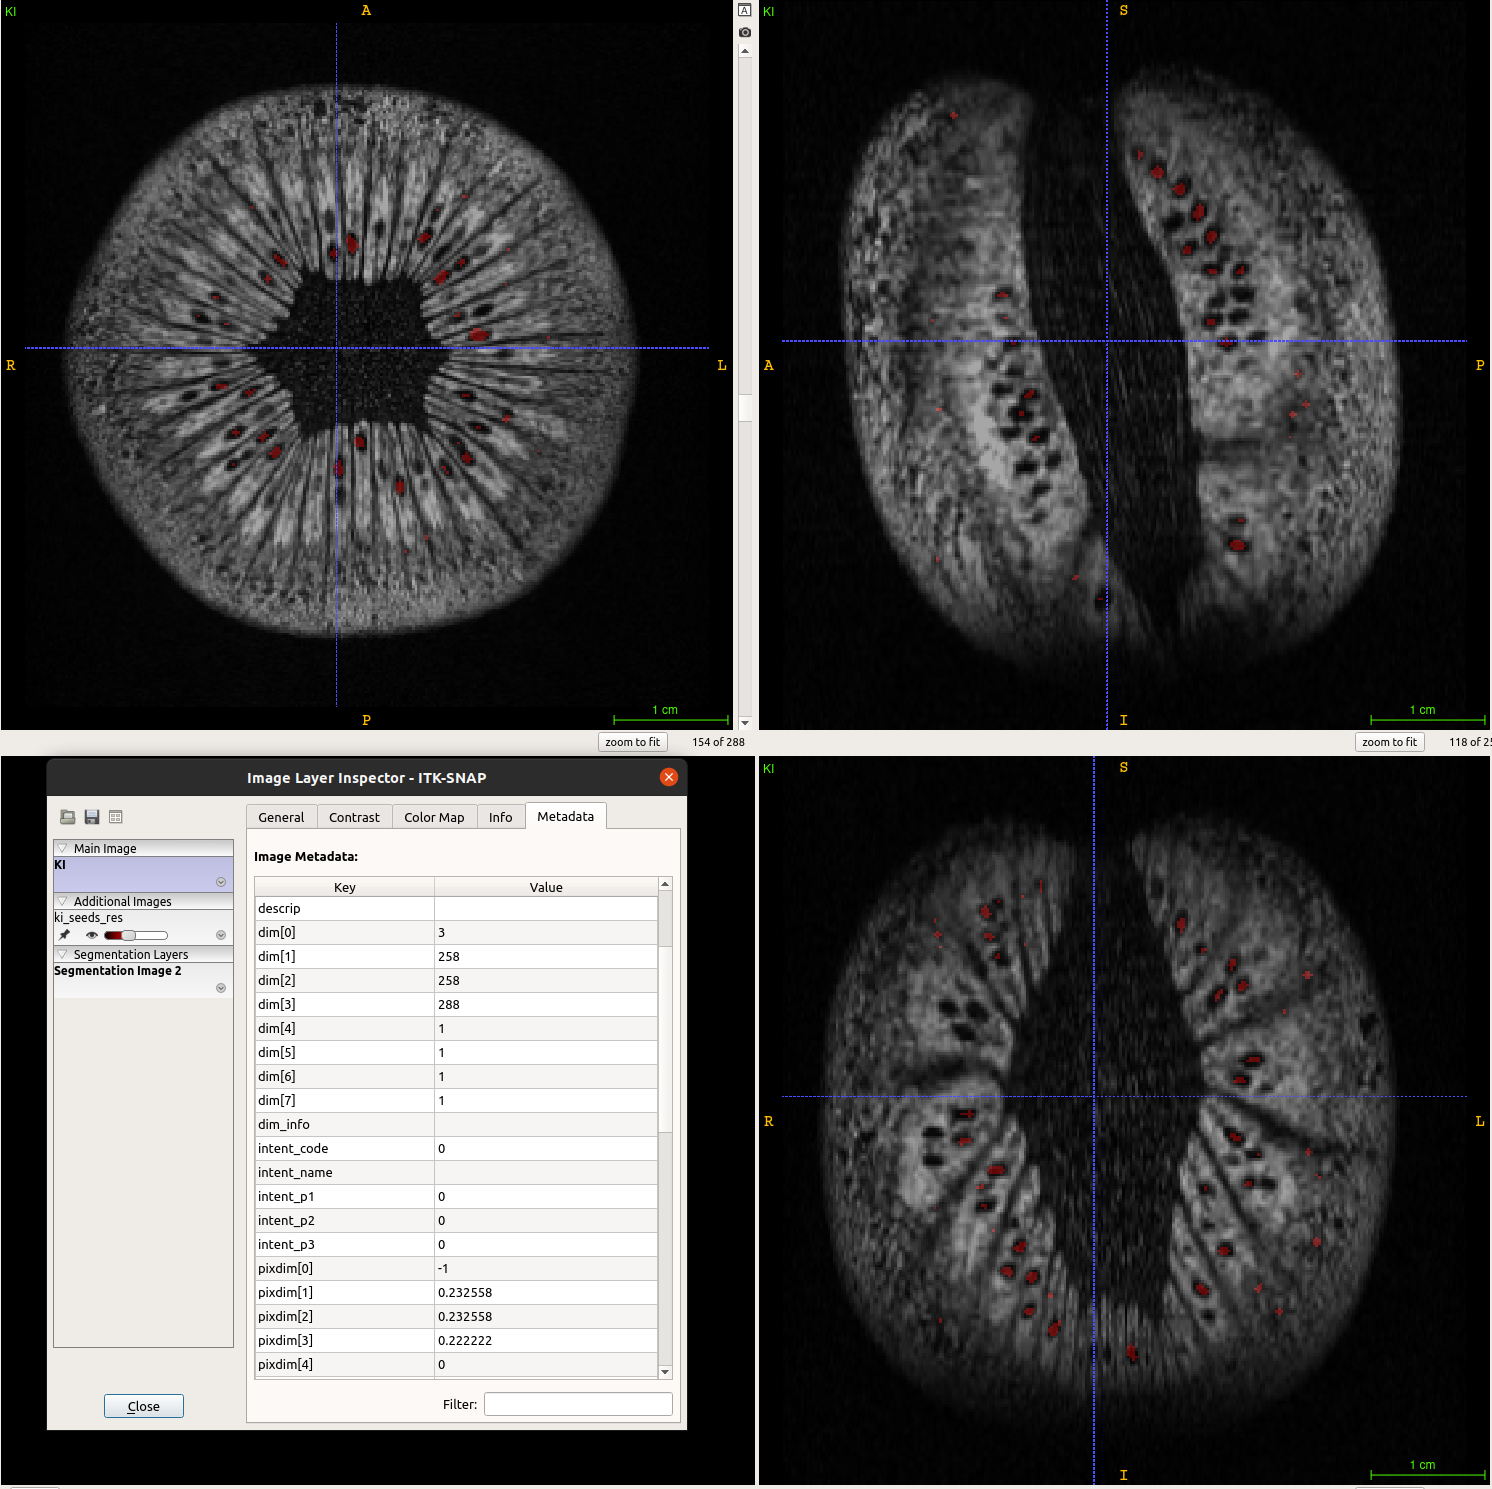

In [115]:
Image(filename='data/ki_seeds_res.png')

### TASK 7: SEEDS STATISTICS
#### MATHEMATICAL MORPHOLOGY LABELING

In [118]:
struct = ndimage.generate_binary_structure(3, 1)
labeled_array, num_features = ndimage.label(seeds_res,struct)

#### LABEL OBJECTS (SEEDS) AND GET THEIR SIZE

In [127]:
# identify the biggest object in the image
lab_size = []
for i in range(labeled_array.max()):
    lab_size.append(len(labeled_array[labeled_array==i]))
# find the biggest object and its index
ki_seeds = max(lab_size[1:])
maxobjidx = lab_size.index(ki_seeds)
print("The biggest element has index equalled to %i and contains %i voxels.\n"%(maxobjidx, ki_seeds))

The biggest element has index equalled to 1551 and contains 151 voxels.



In [246]:
seeds_df = pd.DataFrame.from_dict({'label':list(range(1,len(lab_size[1:])+1)),'voxels':lab_size[1:]})
seeds_df.head()

label  voxels
0      1       7
1      2       7
2      3      12
3      4       7
4      5       7

#### Assess the volume of each sead

In [240]:
vox_dim = ki_nii.header['pixdim'][1:4]
vox_dim

array([0.23255815, 0.23255815, 0.22222222], dtype=float32)

In [241]:
vox_vol = np.prod(vox_dim)
vox_vol

0.012018509

In [242]:
seeds_df['vol'] = seeds_df['voxels'] * vox_vol
seeds_df.sort_values(by='vol', ascending=False, inplace=True)

In [243]:
seeds_df.head()

label  voxels       vol
1550   1550     151  1.814795
1067   1067     143  1.718647
266     266     140  1.682591
921     921     132  1.586443
940     940     121  1.454240

In [166]:
seeds_df.tail()

voxels      vol
1140       7  0.08413
1139       7  0.08413
1138       7  0.08413
1206       7  0.08413
0          7  0.08413

### SEED STATISTISC

In [187]:
seeds_stats_df = pd.DataFrame.from_dict({'median':seeds_df.median(), 'mean':seeds_df.mean(), 'std':seeds_df.std()})
seeds_stats_df.round(3)

median    mean     std
voxels  21.000  26.249  18.964
vol      0.252   0.315   0.228

Text(1.0092216868887622, 220, 'mean+3 std')

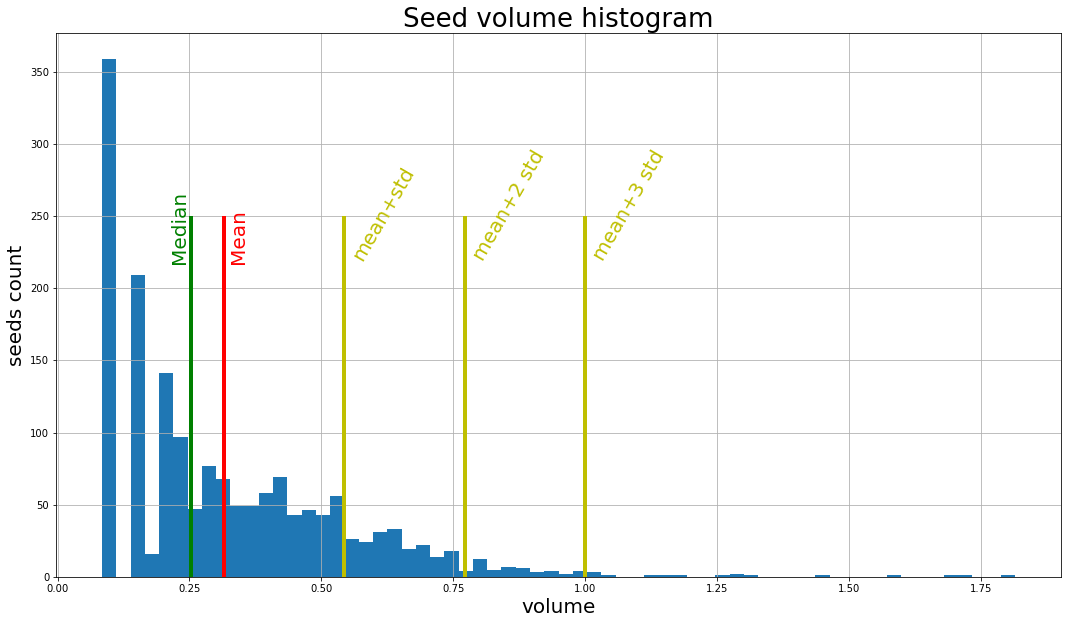

In [235]:
f, ax = plt.subplots(figsize=(18,10))
h = seeds_df.vol.hist(bins=64, ax=ax)
ax.set_title('Seed volume histogram', fontsize=26)
ax.set_xlabel('volume', fontsize=20)
_ = ax.set_ylabel('seeds count', fontsize=20)
ax.vlines(seeds_df.vol.mean(), 0, 250, colors='r', linewidth=4)
ax.text(seeds_df.vol.mean()+0.01, 220, 'Mean', c='r', fontsize=20, rotation=90)

ax.vlines(seeds_df.vol.median(), 0, 250, colors='g', linewidth=4)
ax.text(seeds_df.vol.median()-0.04, 220, 'Median', c='g', fontsize=20, rotation=90)

st = seeds_df.vol.std()
mn = seeds_df.vol.mean()
ax.vlines(mn+st, 0, 250, colors='y', linewidth=4)
ax.text(mn+st+0.01, 220, 'mean+std', c='y', fontsize=20, rotation=60)

ax.vlines(mn+st+st, 0, 250, colors='y', linewidth=4)
ax.text(mn+st+st+0.01, 220, 'mean+2 std', c='y', fontsize=20, rotation=60)

ax.vlines(mn+st+st+st, 0, 250, colors='y', linewidth=4)
ax.text(mn+st+st+st+0.01, 220, 'mean+3 std', c='y', fontsize=20, rotation=60)

In [236]:
seeds_df.head()

voxels       vol
1550     151  1.814795
1067     143  1.718647
266      140  1.682591
921      132  1.586443
940      121  1.454240

voxels    26.249255
vol        0.315477
dtype: float64